# Importing

In [2]:
import numpy as np
import pandas as pd
import itertools as it

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import scipy.stats as stats
from scipy.stats import ks_2samp
import GRIN_analysis_tools as ga

from path import Path
import warnings
from warnings import warn
from collections import OrderedDict
import itertools
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import minmax_scale, scale
from sklearn import preprocessing
from scipy.integrate import simps
from numpy import trapz
from sklearn.metrics import auc
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

path = 'dataset/'
# export_path = '/Volumes/lab-kohlj/home/shared/projects/pregnancy_2021/Figure_4/linked_figure_4/' 
export_path = 'output_figures/'

## preprocessing

### interpld behaviour annotation to inscopix recording (only need to do it once)

In [3]:
ID = 'JKAA48.3d'
state = 'PD18'
convolve = 'non_convolved'

df = ga.load_inscopix(path + f'{ID}/{convolve}/{ID}_registered_{state}'+'.csv', normalisation='fixed interval')
bdf = ga.interpld('dataset/'f'{ID}/{ID}_behav_{state}.csv', df.shape[1])
bdf.to_csv(path + f'{ID}/{ID}_behav_{state}' + '_post.csv')

# Evoked response analysis

## plot population activities evoked by different behaviours

In [4]:
# Path to calcium and behaviour recordings
path = 'dataset/'

# Experimental conditions
states = ['virgin','PD18', 'PD50']

# Analysis parameters

IDs = ['JKAA40.3e','JKAA40.4i','JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']

convolve = 'non_convolved'

fr = 20
window = 2


# The number of behavioural episodes used to estimate tuning per behaviour type
num_episodes = {'pup sniff':1,
                'pup groom':1,
                'nest time':1,
                'crouching':1,
                'retrieval to nest':1,
                'male intruder contact':1,
                'female intruder contact':1}

populations_v = pd.DataFrame(columns = ['State', 'Behav', 'Activities'])
populations_P = pd.DataFrame(columns = ['State', 'Behav', 'Activities'])
populations_D = pd.DataFrame(columns = ['State', 'Behav', 'Activities'])

# Calculating tuning for all recordings



for state in states:
    
    activity = np.empty([0, fr * window])
    population = {}

    for ID in IDs:

        try:
            episodes = ga.population_activities(path, 
                                          state,
                                          ID, 
                                          convolve,
                                          window = window, 
                                          num_episodes = num_episodes,
                                          skip_overlap = False,
                                          z_scored = True)   
            

        except FileNotFoundError:
            warnings.warn(f'Recording {ID}_{state} was not found')
            episodes = []
        
        for behav in num_episodes.keys():
            
            
            if episodes == []:
                break

            else:
                try:
                    population['IDs'] = [ID]
                    population['State'] = [state]
                    population['Behav'] = [behav]
                    population['Activities'] = [episodes[behav]]
                    population = pd.DataFrame(population)
                    
                    if state == 'virgin':
                        
                        populations_v = pd.concat([populations_v,population])
                    
                    elif state == 'PD18':
                        populations_P = pd.concat([populations_P,population])
                        
                    else:
                        populations_D = pd.concat([populations_D,population])
                    
                except KeyError:
                    pass


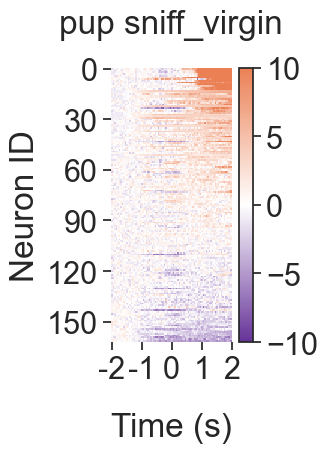

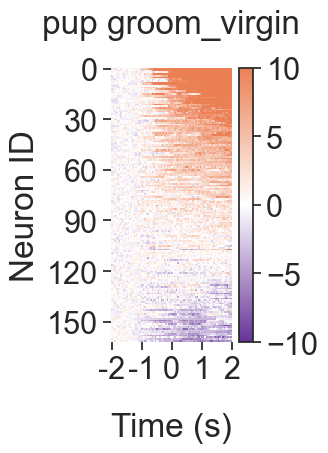

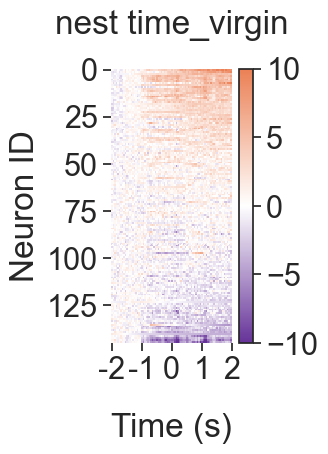

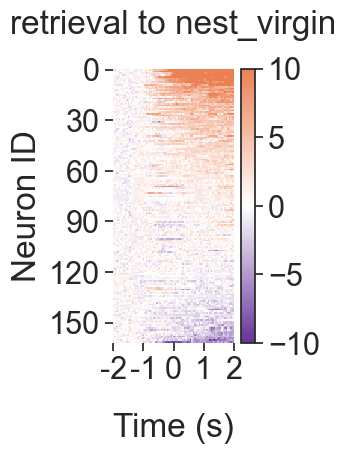

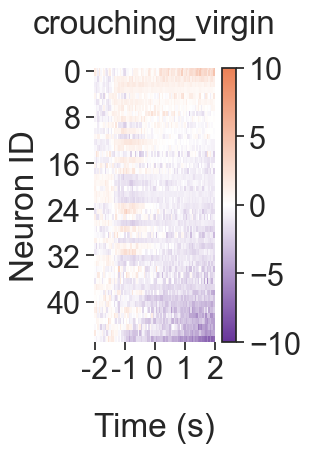

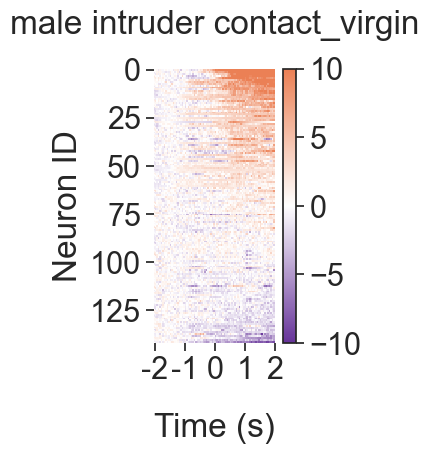

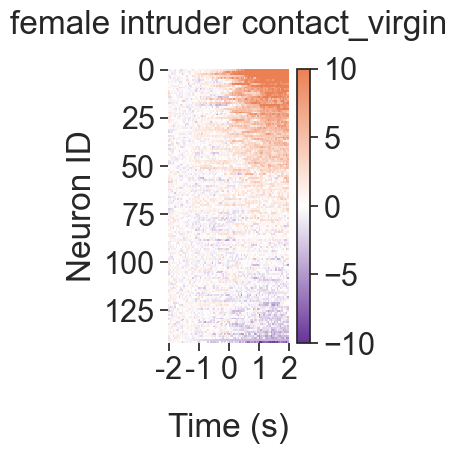

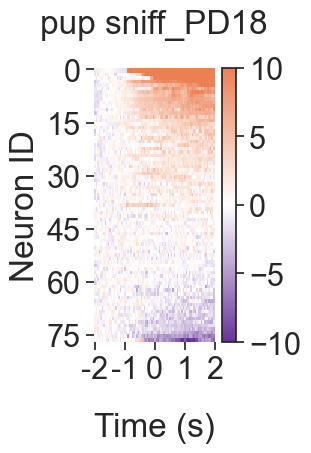

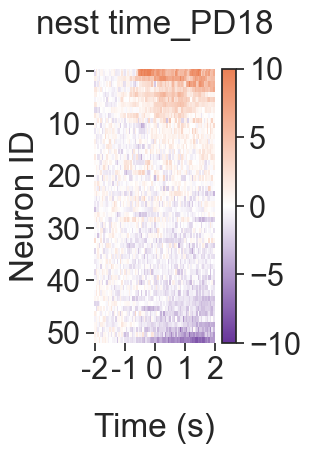

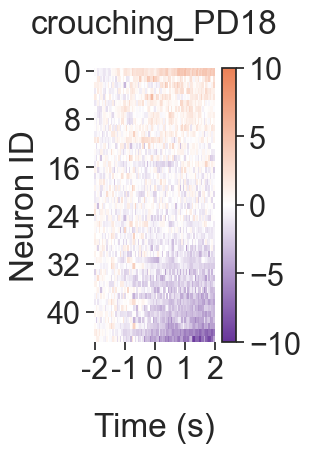

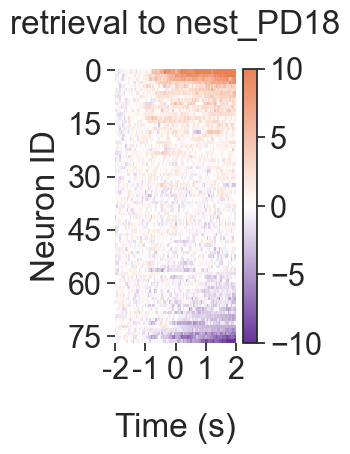

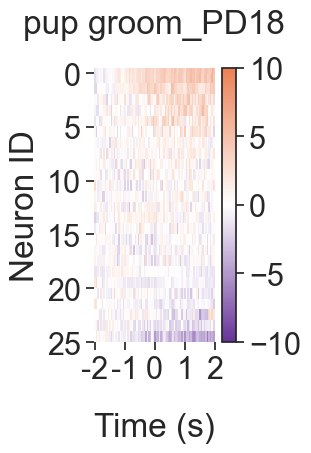

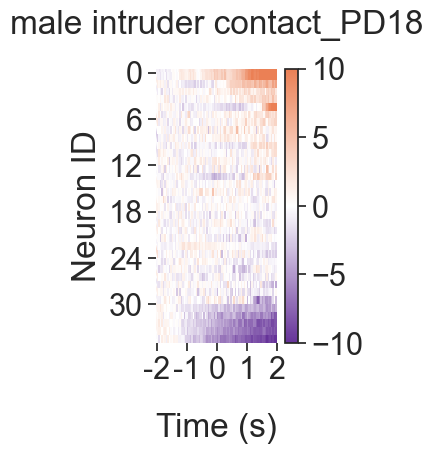

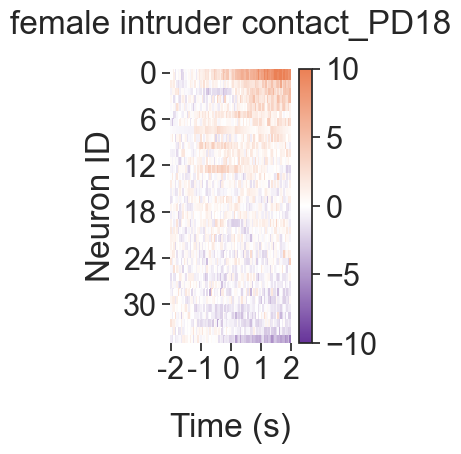

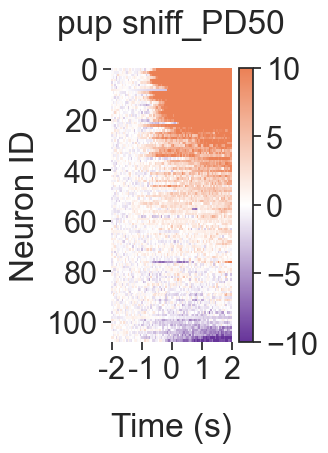

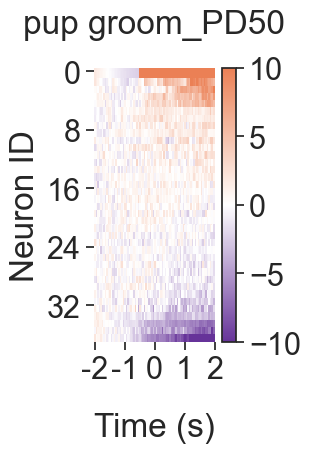

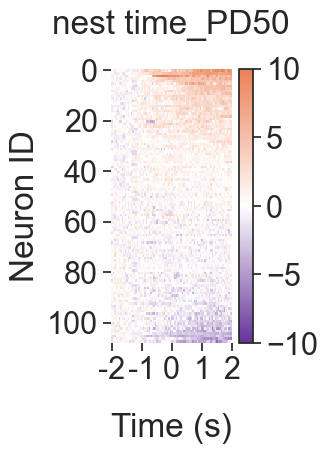

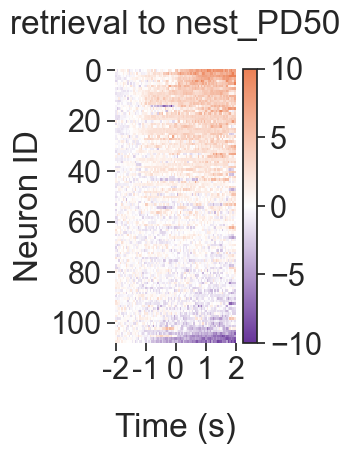

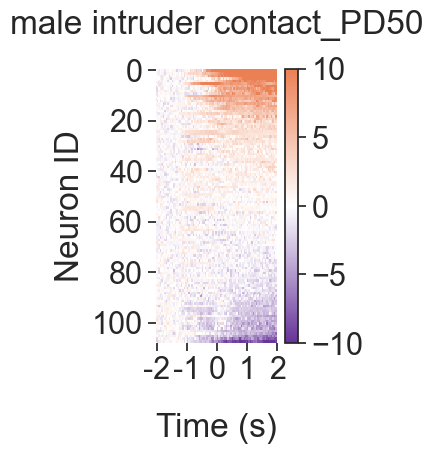

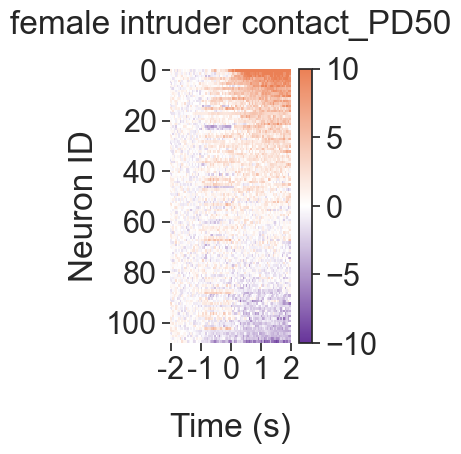

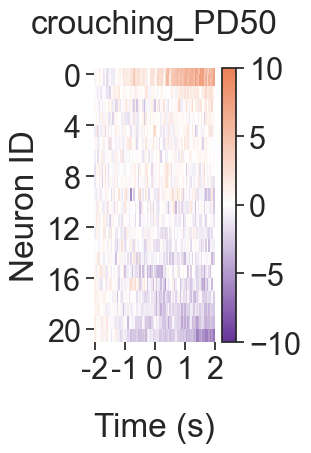

In [5]:
# cmap=LinearSegmentedColormap.from_list('rg',["rebeccapurple", "w", "#eb8055ff"], N=256) 
cmap=LinearSegmentedColormap.from_list('rg',["rebeccapurple", "w", "#eb8055ff"], N=256) 

# cmap = 'PRGn'
for behav in populations_v.Behav.unique():
    activities = np.concatenate(populations_v[populations_v.Behav == behav].Activities.tolist(), axis=0)
    fig = ga.plot_amplitude(activities, behav + '_virgin',cmap, clustering = False)
#     fig.savefig(export_path + str(behav) + '_virgin_heatmap.pdf', dpi=300, transparent=False, bbox_inches = "tight")
#     fig.savefig(export_path + str(behav) + '_virgin.png', dpi=300, transparent=True, bbox_inches = "tight")

for behav in populations_P.Behav.unique():
    activities = np.concatenate(populations_P[populations_P.Behav == behav].Activities.tolist(), axis=0)
    fig = ga.plot_amplitude(activities, behav + '_PD18',cmap, clustering = False)
#     fig.savefig(export_path + str(behav) + '_PD18_heatmap.pdf', dpi=300, transparent=False, bbox_inches = "tight")
#     fig.savefig(export_path + str(behav) + '_PD18.png', dpi=300, transparent=True, bbox_inches = "tight")
    
for behav in populations_D.Behav.unique():
    activities = np.concatenate(populations_D[populations_D.Behav == behav].Activities.tolist(), axis=0)
    fig = ga.plot_amplitude(activities, behav + '_PD50',cmap, clustering = False)
#     fig.savefig(export_path + str(behav) + '_PD50_heatmap.pdf', dpi=300, transparent=False, bbox_inches = "tight")
#     fig.savefig(export_path + str(behav) + '_PD50.png', dpi=300, transparent=True, bbox_inches = "tight")

## plotting zscored episodes for selected behaviour on per mouse basis

In [6]:
# Path to calcium and behaviour recordings
path = 'dataset/'

# Experimental conditions
states = ['virgin','PD18', 'PD50']

# Analysis parameters

IDs = ['JKAA40.3e','JKAA40.4i','JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']

convolve = 'non_convolved'

fr = 20
window = 2
average_estimates = False
num_episodes = 5
untuned_boundary = 0

# The number of behavioural episodes used to estimate tuning per behaviour type
num_episodes = {'pup sniff':1,
                'retrieval to nest':1,
                'pup groom' :1,
                'nest time':1,
                'crouching':1,
                'male intruder contact':1,
                'female intruder contact':1}

behav_zscored = pd.DataFrame(columns = ['State', 'Cell', 'Activities'])
zscores = pd.DataFrame(columns = ['State', 'Behaviour', 'IDs', 'Mouse', 'Mean_episode_activities', 'non_z'])
activities = np.empty([0, fr * window*2])

# Calculating tuning for all recordings

for state in states:

    for ID in IDs:

        try:
            episodes = ga.population_activities(path, 
                                             state,
                                             ID, 
                                             convolve,
                                             window = window, 
                                             num_episodes = num_episodes,
                                             skip_overlap = False,
                                             z_scored = True)
            
            non_z = ga.population_activities(path, 
                                          state,
                                          ID, 
                                          convolve,
                                          window = window, 
                                          num_episodes = num_episodes,
                                          skip_overlap = False,
                                          z_scored = False)  

      
        
        except FileNotFoundError:
            warnings.warn(f'Recording {ID}_{state} was not found')
            episodes = []
        
         

        for behav in num_episodes.keys():
            
            
            if episodes == []:
                break

            else:
                try:
       
                    num_cells = episodes[behav].shape[0]
                    zscore = {}

                    zscore['State'] = [state]
                    zscore['Behaviour'] = [behav] 
                    zscore['IDs'] = [ID]
                    zscore['Mouse'] = [f'{ID}'] 

                    episodes[behav][np.isnan(episodes[behav])] = 0
                    zscore['Mean_episode_activities'] = [episodes[behav]]
                    zscore['non_z'] = [non_z[behav]]
                    zscore = pd.DataFrame(zscore)
                    zscores = pd.concat([zscores, zscore])
                    activities = np.concatenate((activities, episodes[behav]), axis = 0)
                    
                except KeyError:
                    pass
        

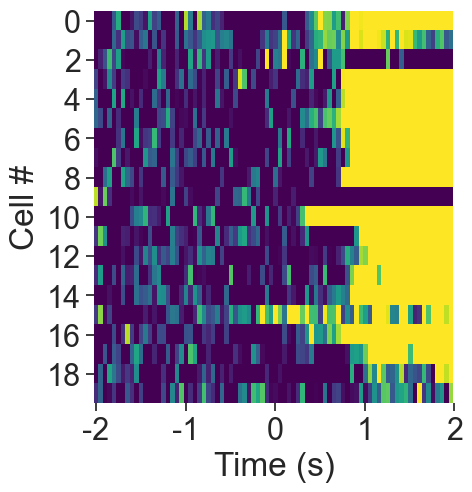

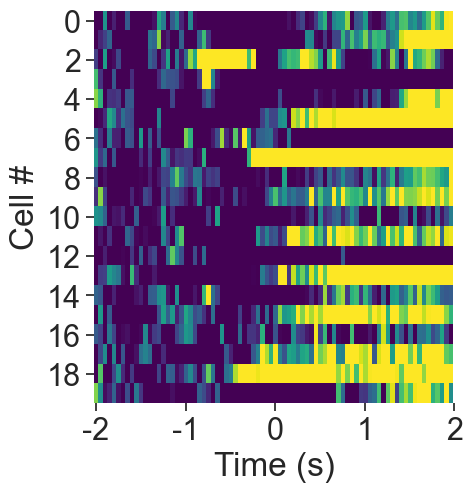

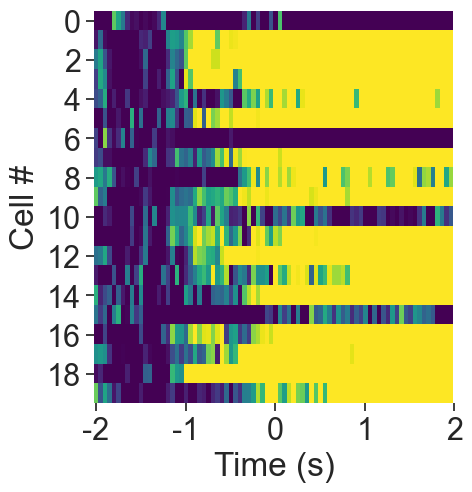

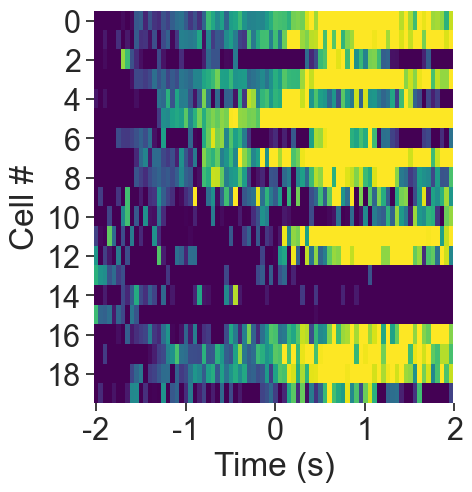

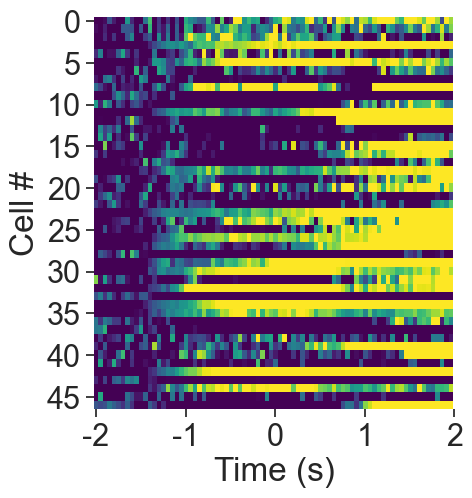

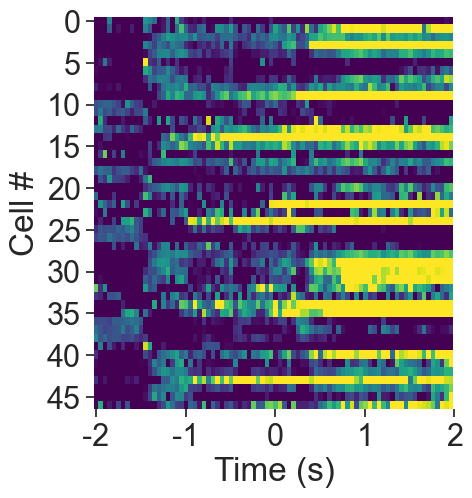

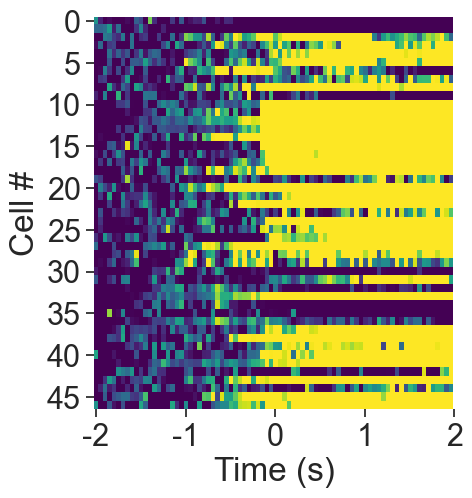

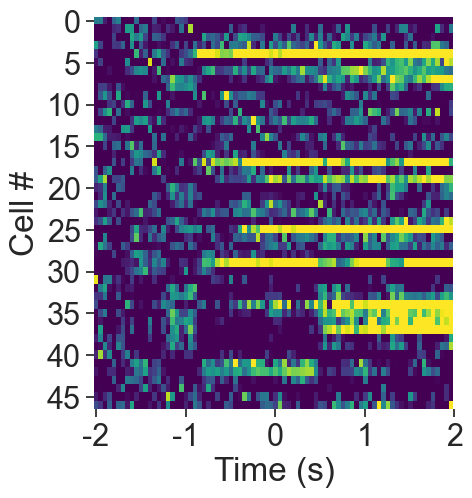

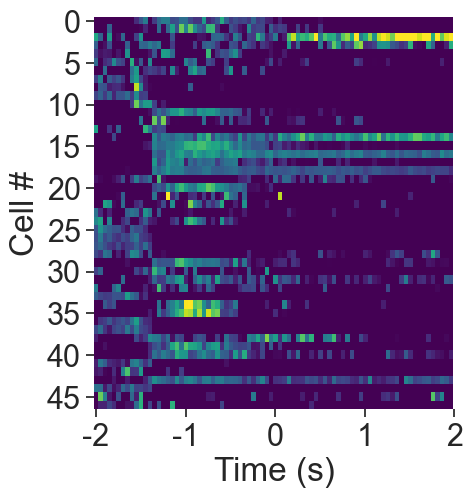

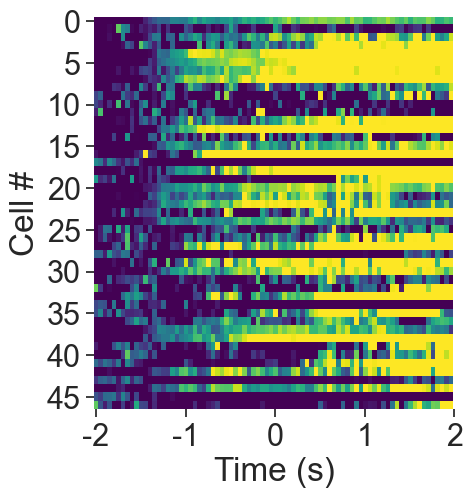

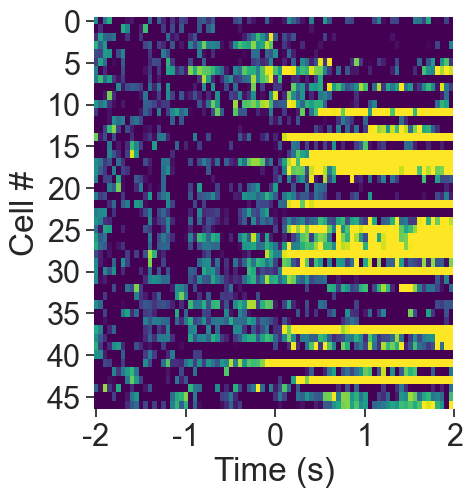

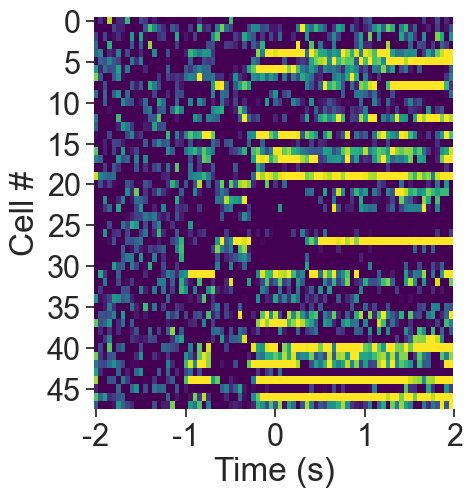

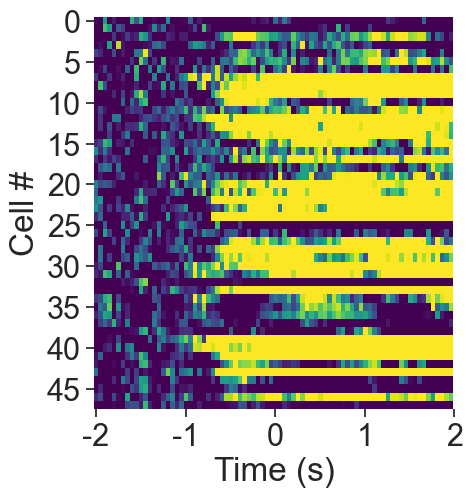

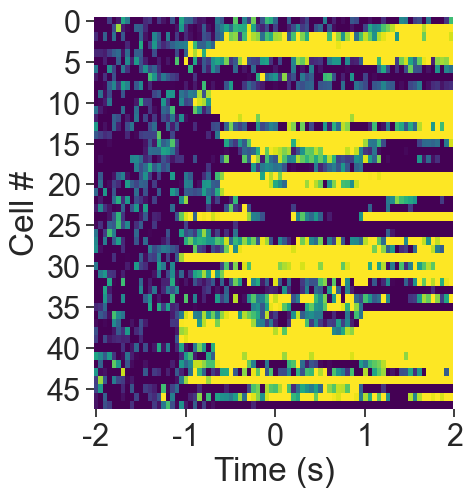

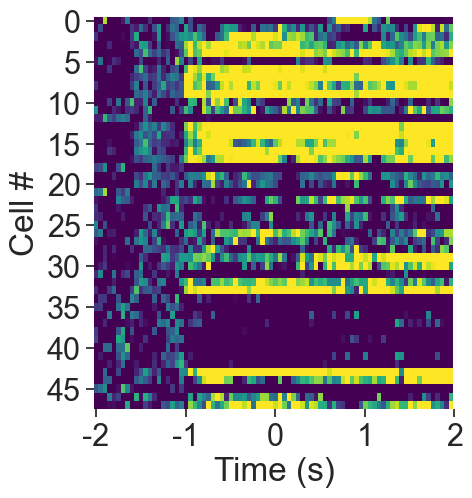

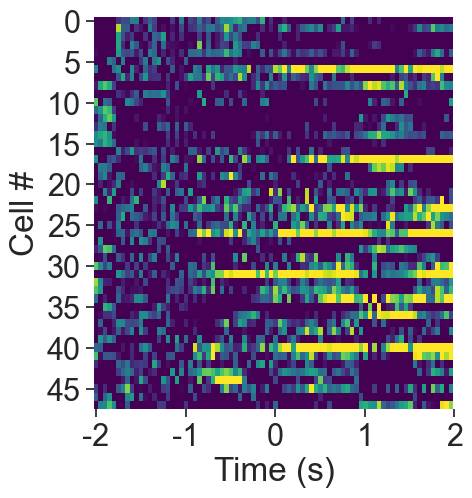

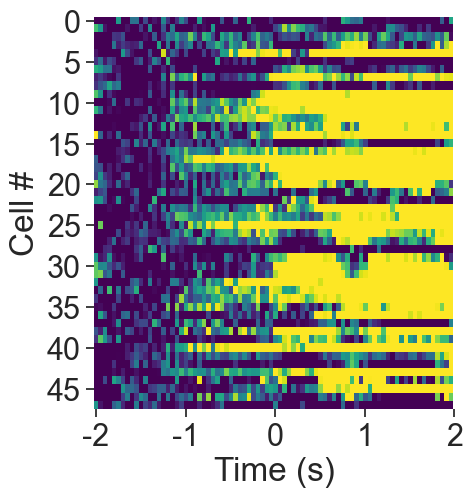

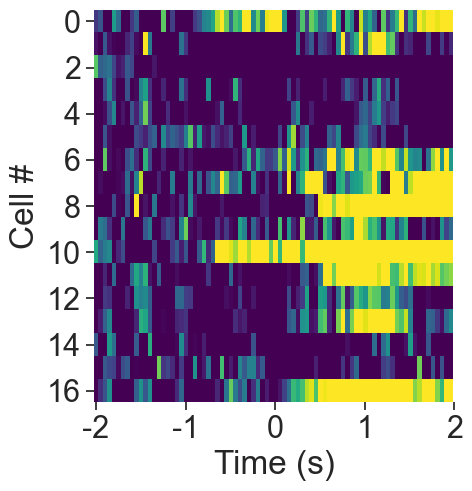

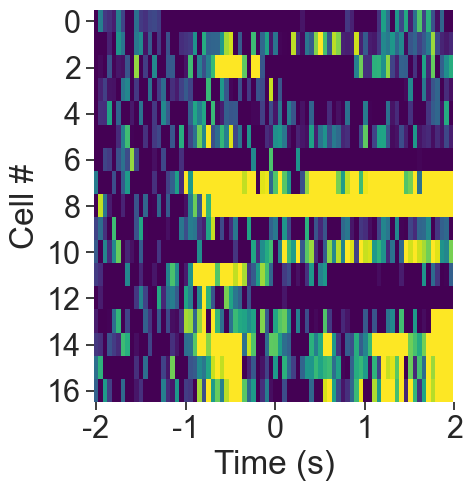

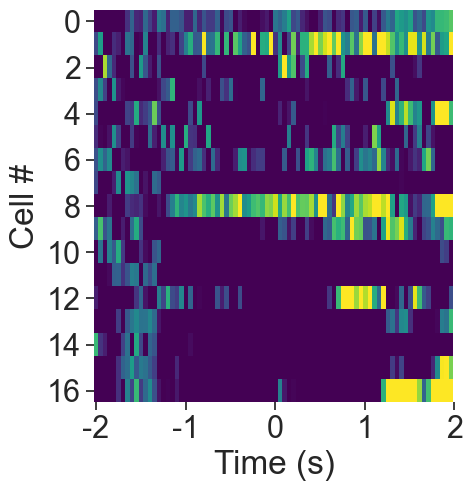

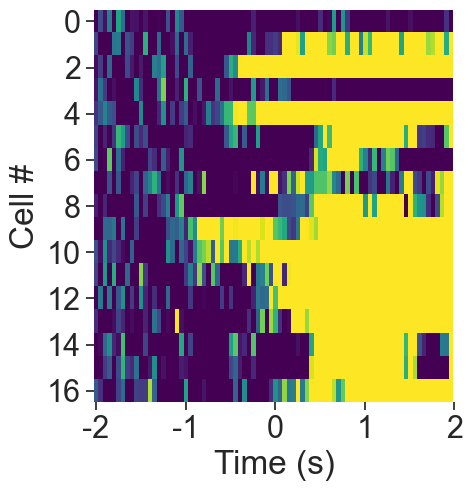

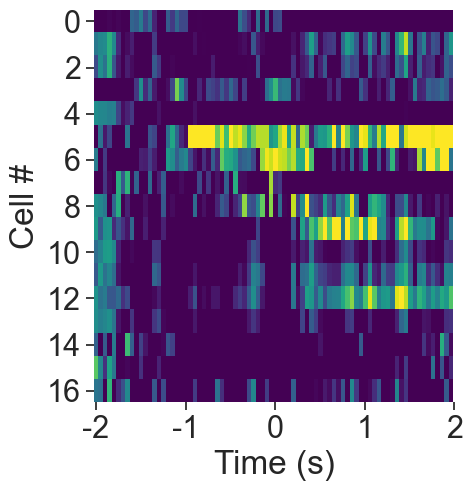

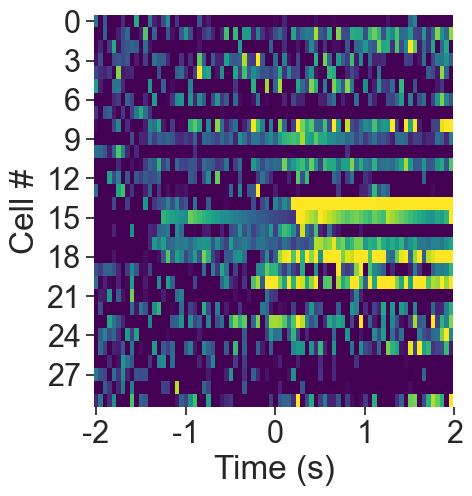

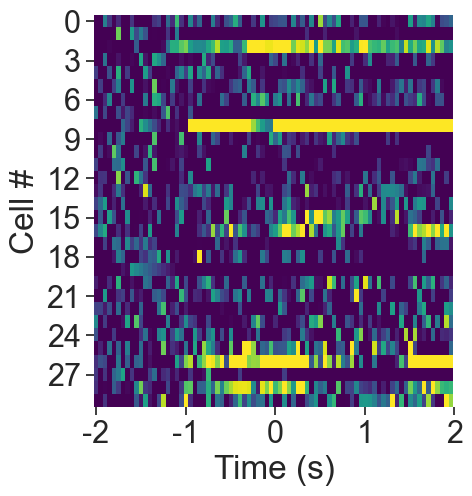

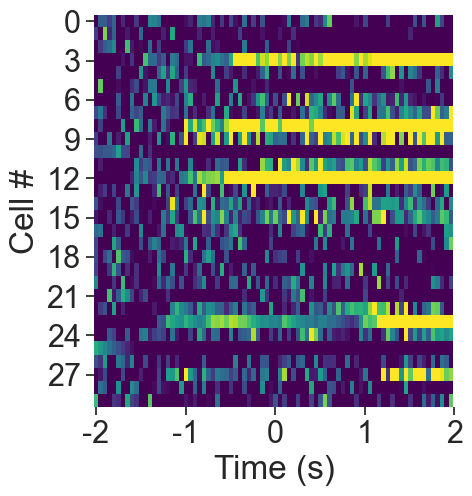

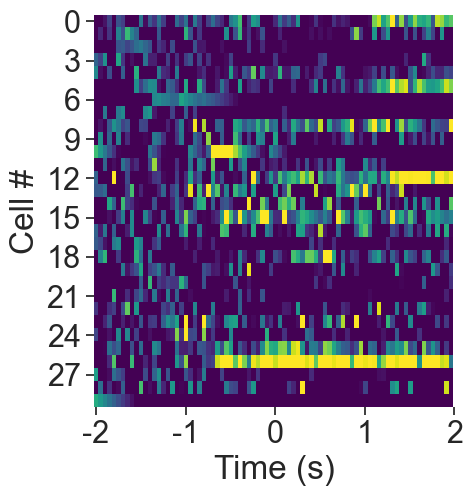

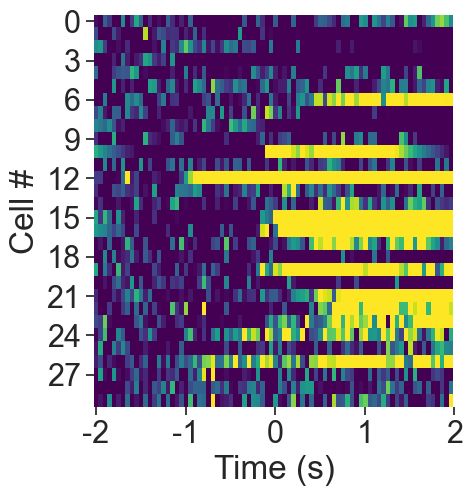

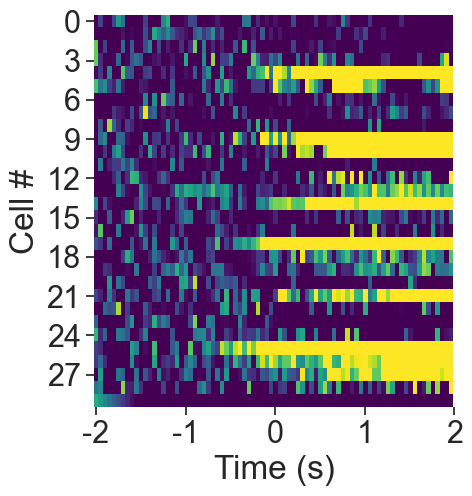

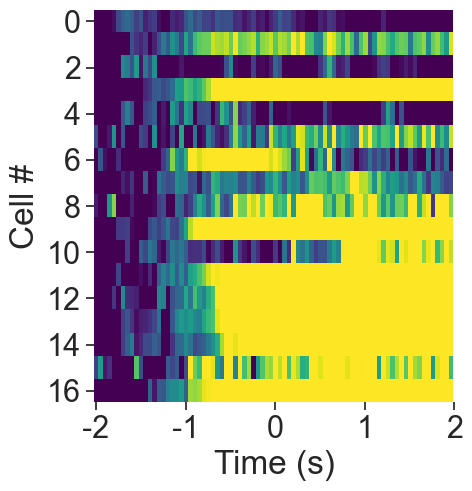

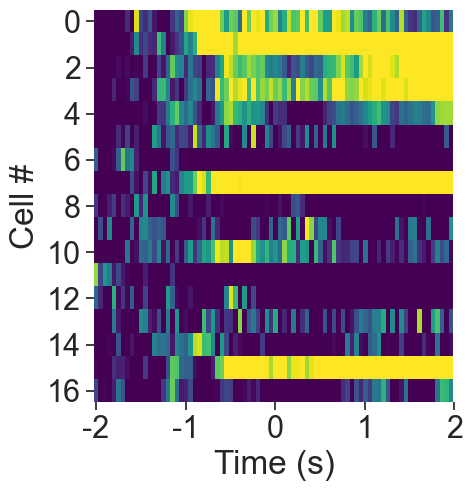

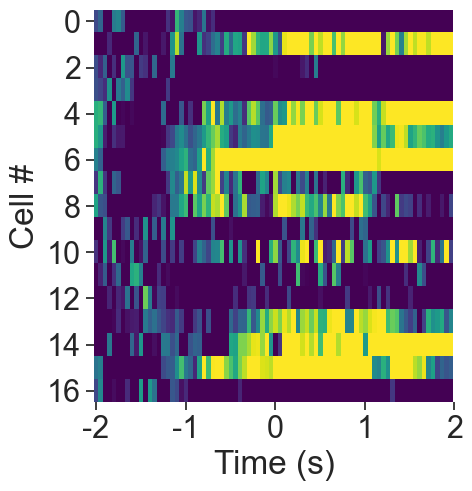

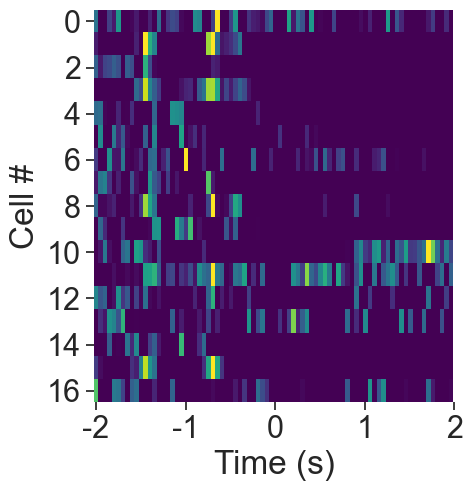

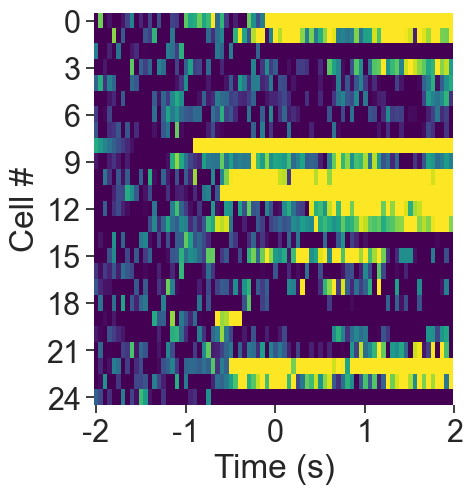

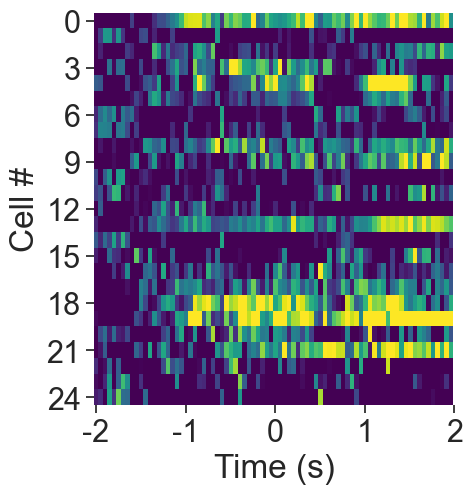

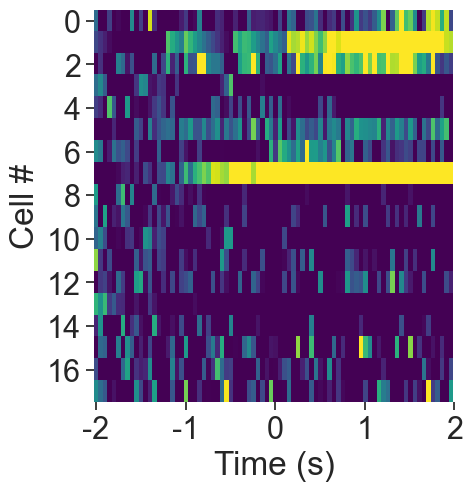

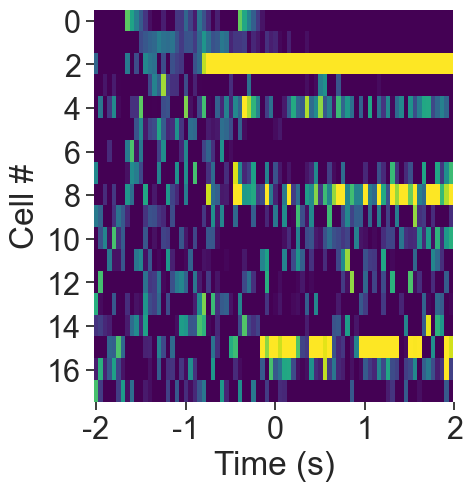

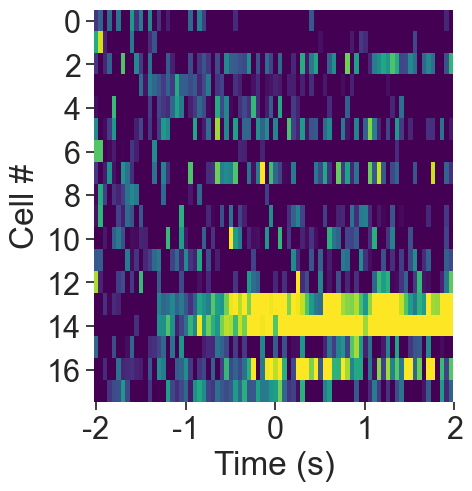

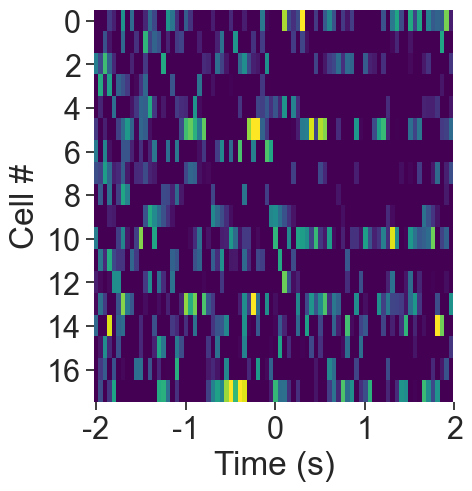

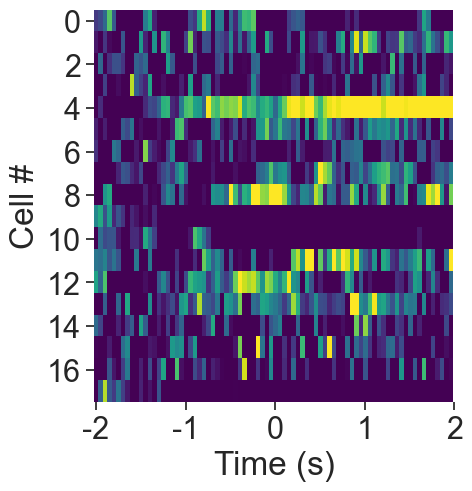

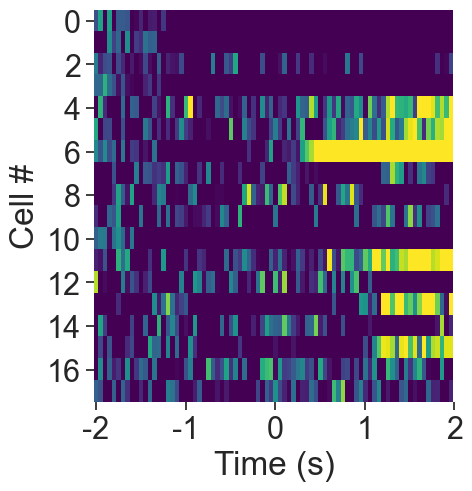

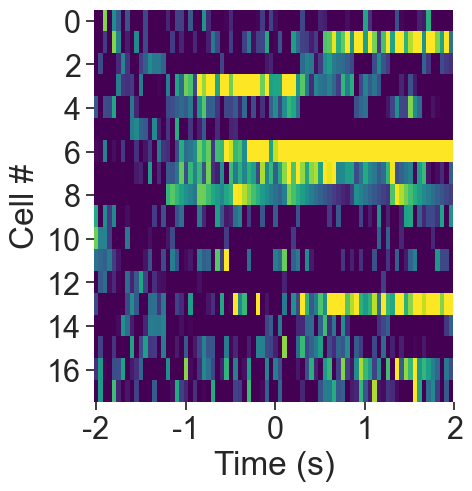

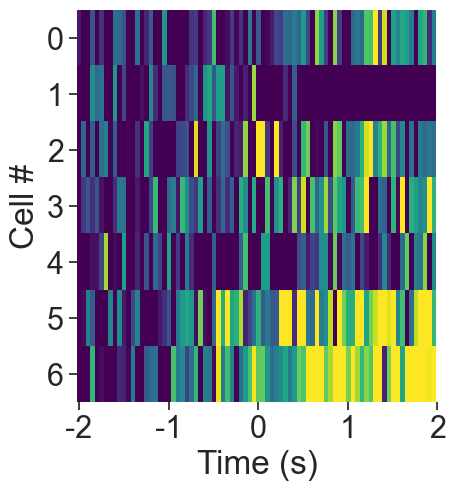

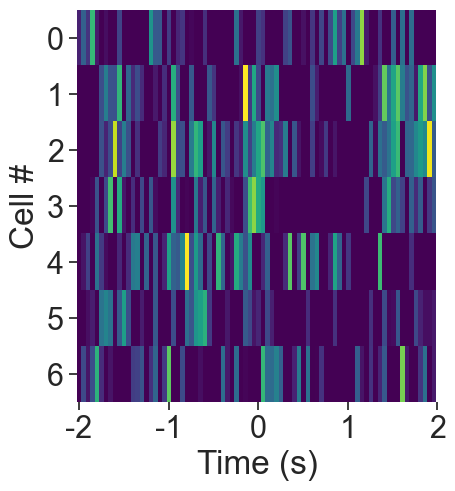

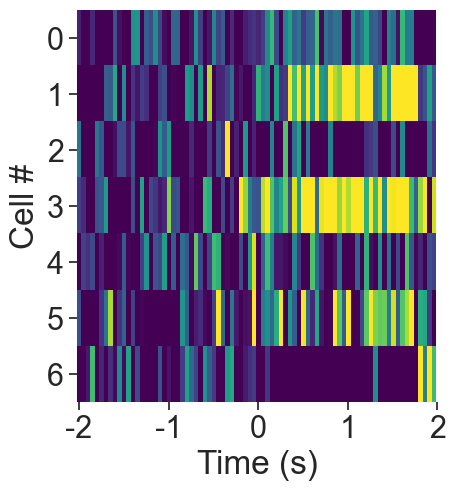

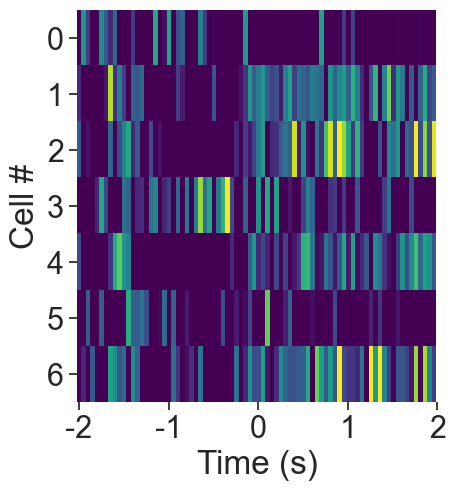

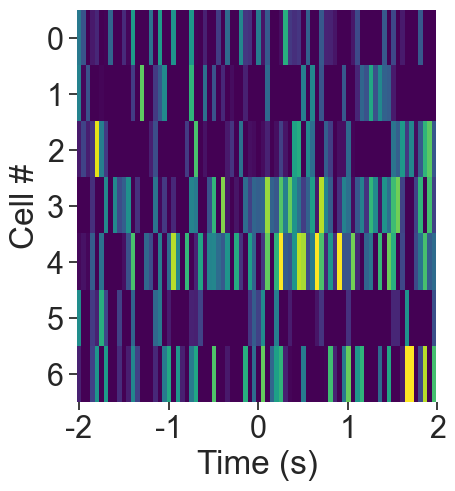

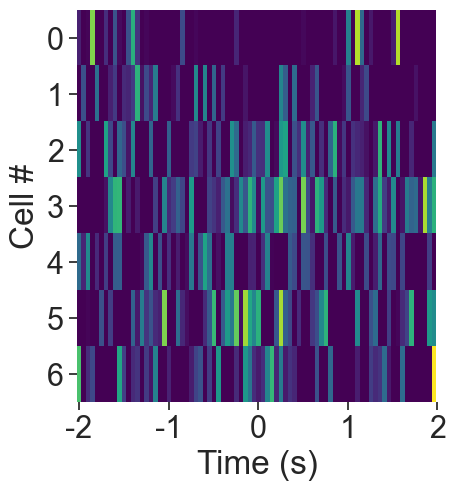

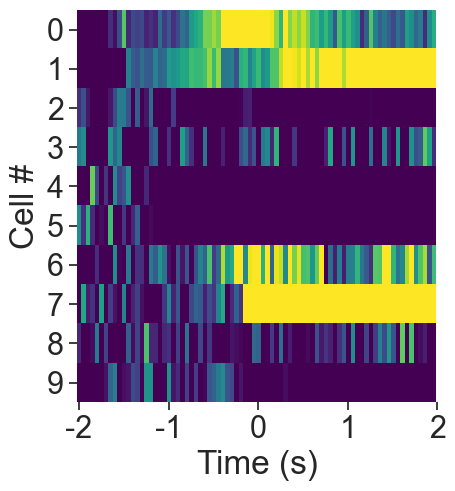

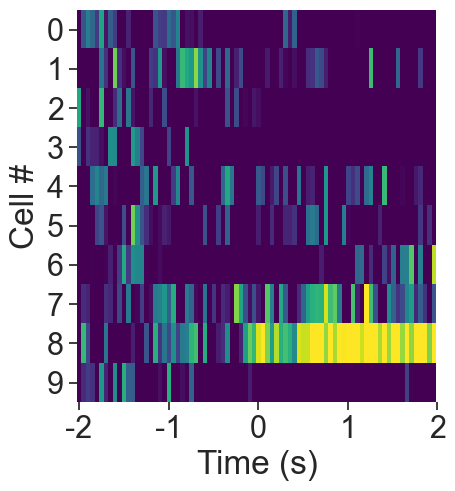

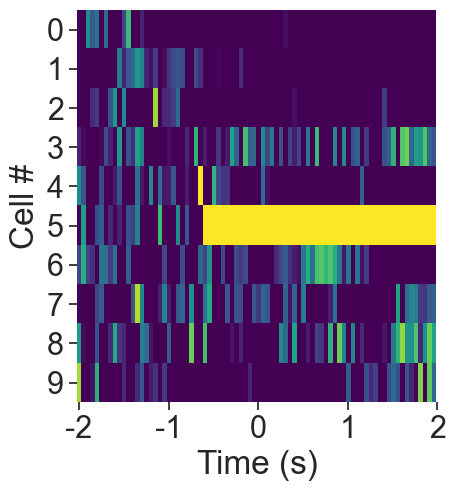

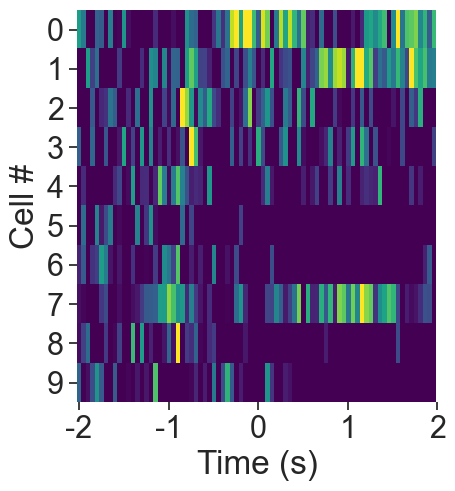

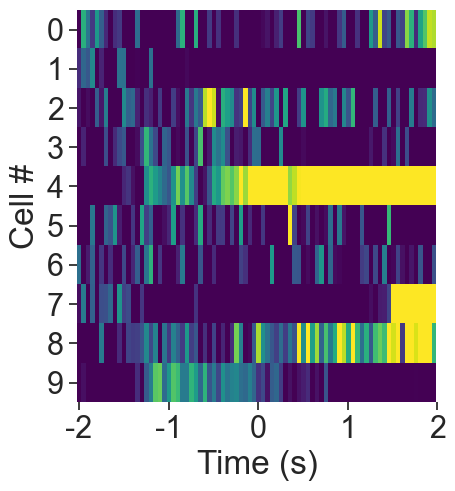

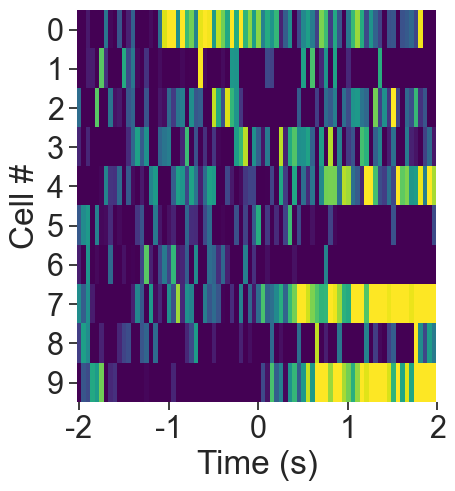

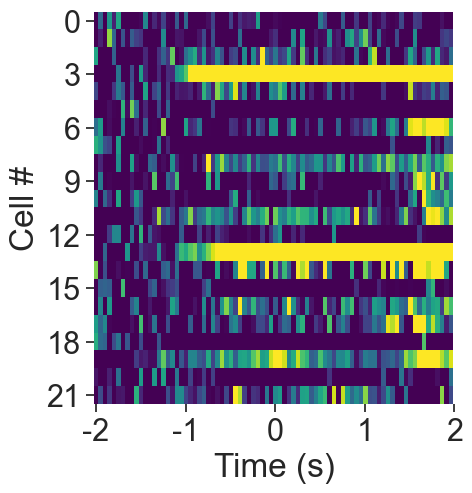

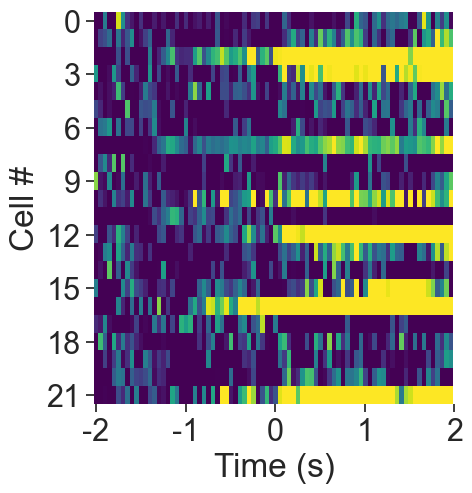

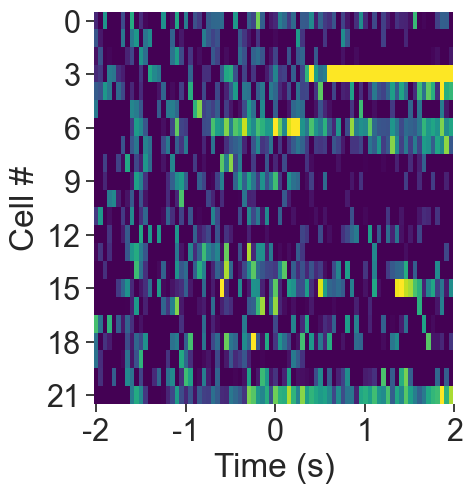

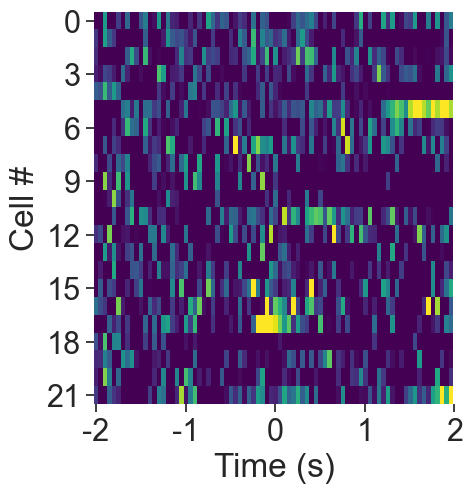

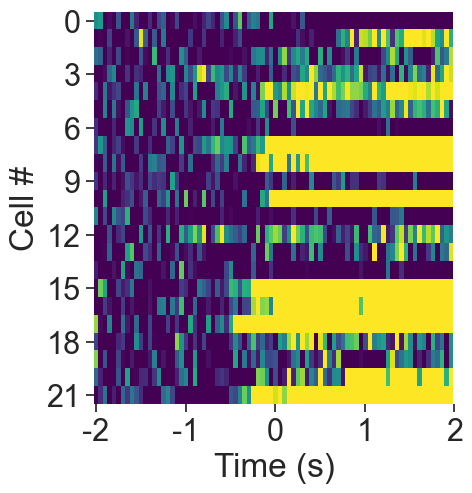

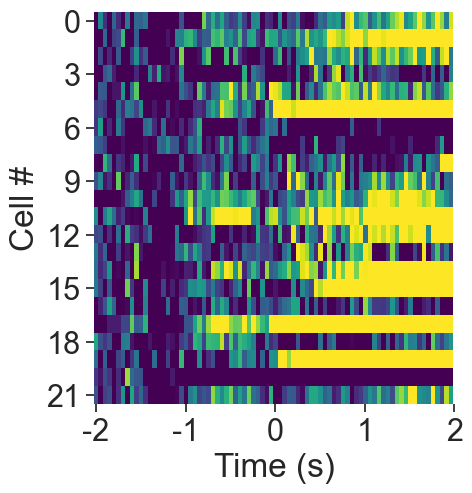

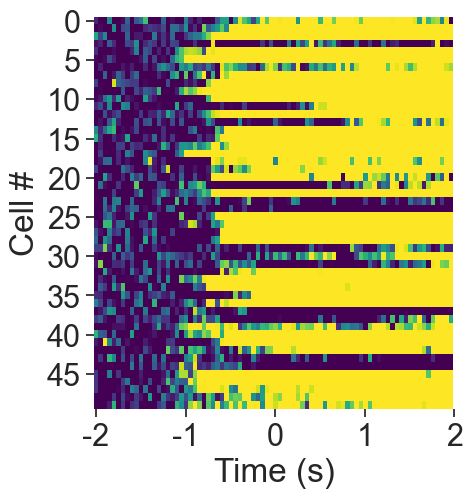

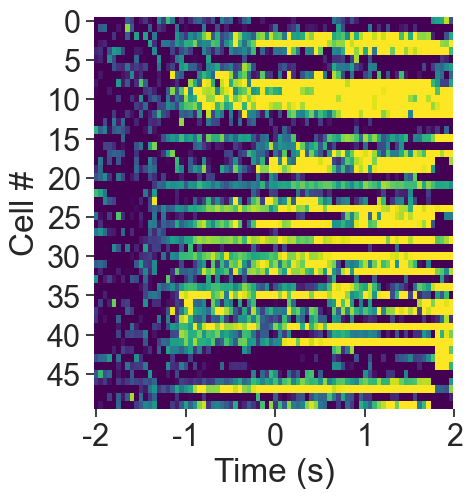

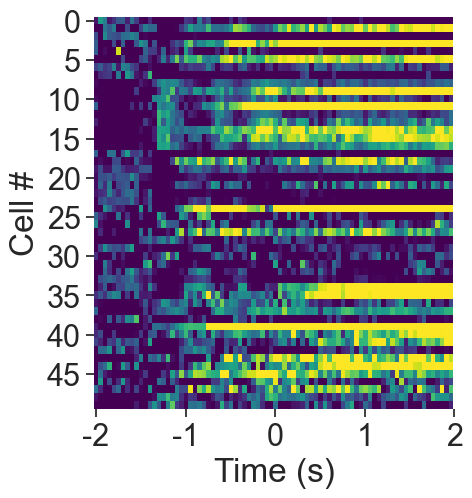

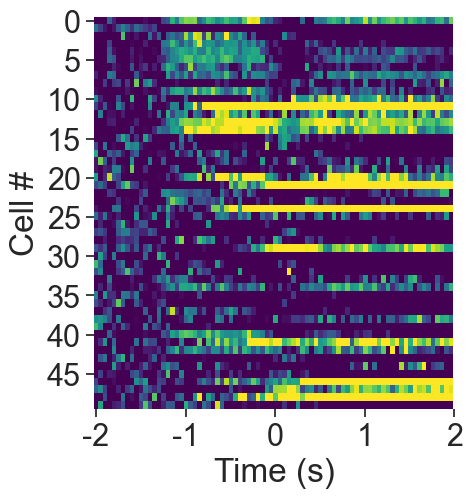

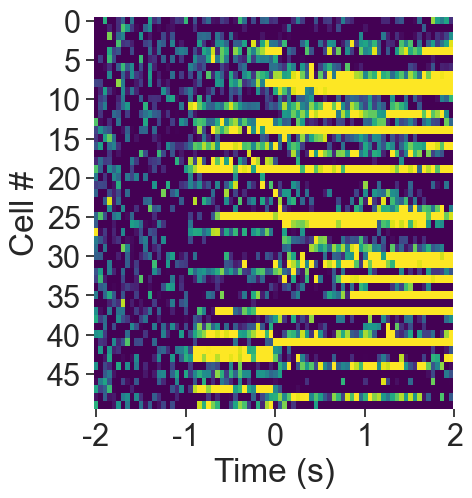

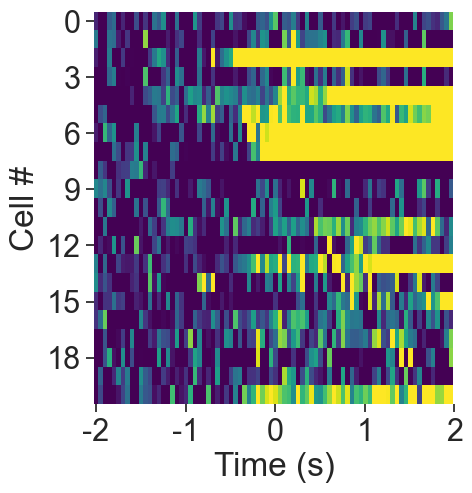

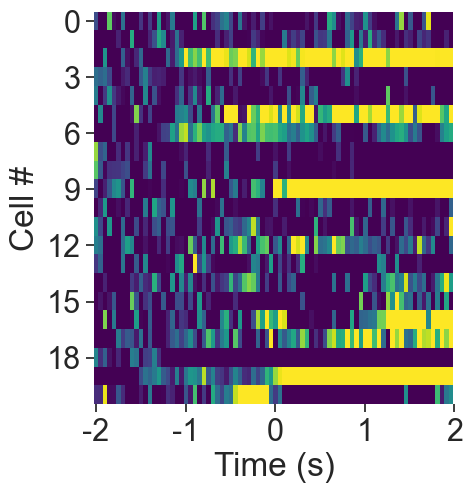

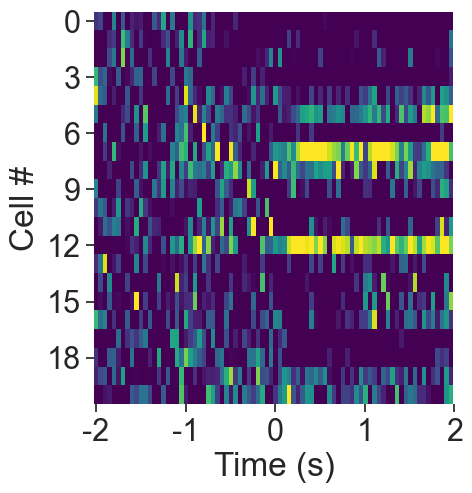

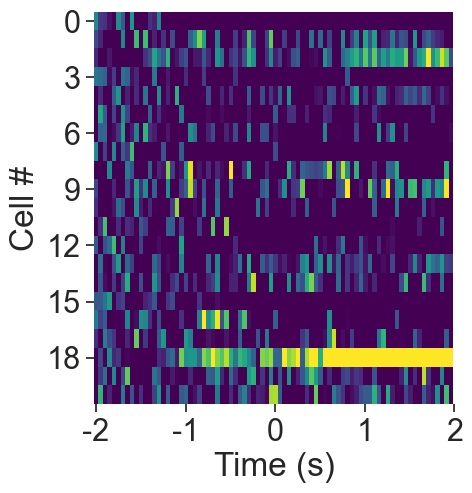

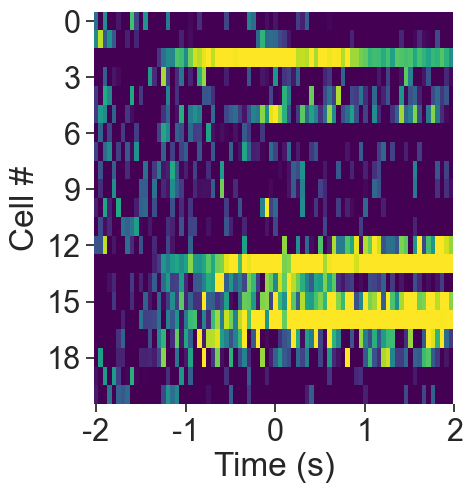

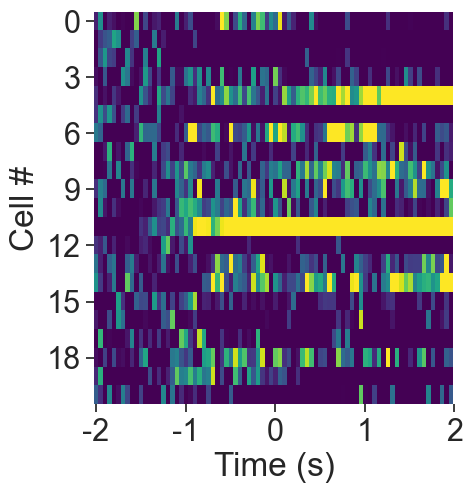

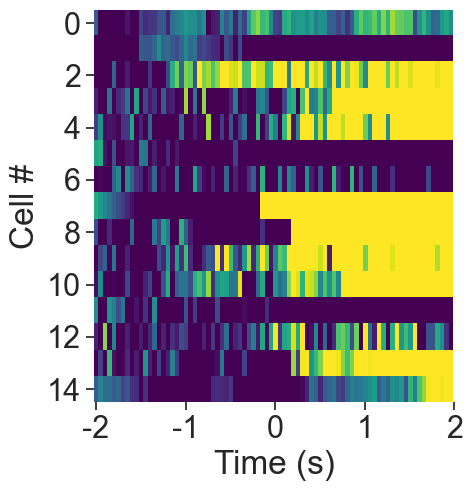

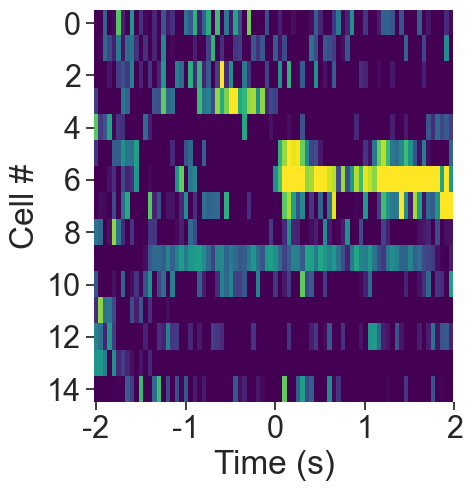

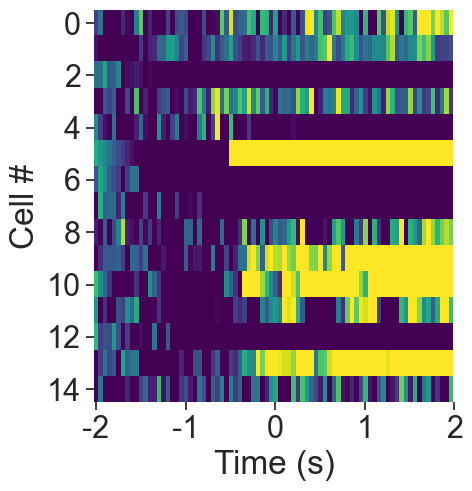

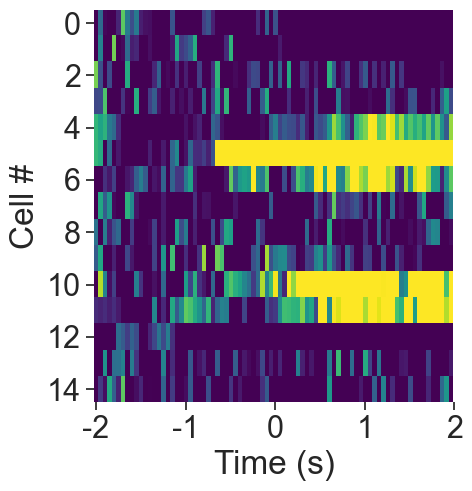

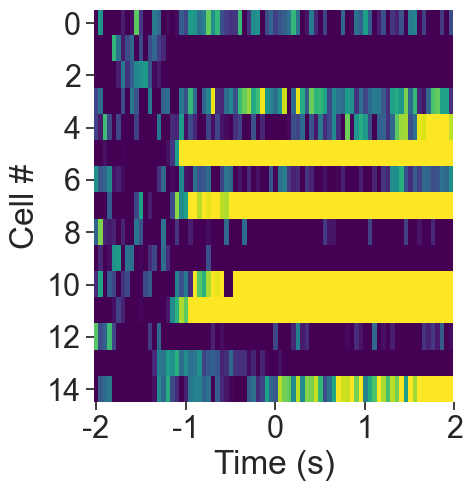

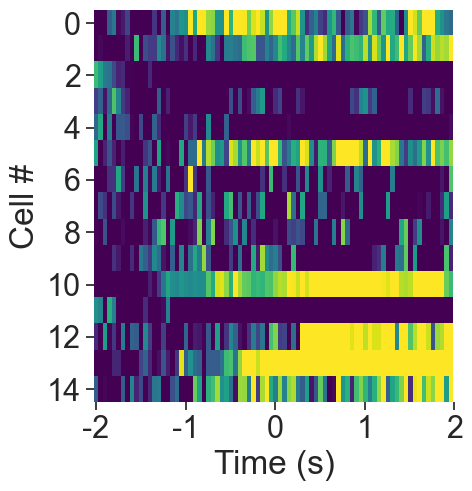

In [7]:
for i in range(zscores.Mean_episode_activities.shape[0]):
    ga.plot_zscore(zscores.Mean_episode_activities.iloc[i], [])

### determine whether single neurons' evoked response to a certain behaviour is significant

In [8]:
behaviours = ['pup sniff','retrieval to nest', 'pup groom', 'male intruder contact', 'female intruder contact', 'nest time', 'crouching'] # JK added pup groom
fr = 20



neurons = pd.DataFrame(columns = ['State', 
                                  'Behaviour', 
                                  'IDs', 
                                  'Cell_index',
                                  't_value',
                                  'Mean_change',
                                  'non_z',
                                  'Change',
                                  'Significance'])



for state in states:
    for ID in IDs:
    
        for behaviour in behaviours:

            mean_activities = zscores[(zscores.State == state)&
                                      (zscores.Behaviour == behaviour)
                                      & (zscores.IDs == ID)].Mean_episode_activities
            non_z = zscores[(zscores.State == state)&
                            (zscores.Behaviour == behaviour)
                            & (zscores.IDs == ID)].non_z
            
            
           
            if mean_activities.empty:
                
                continue
                
                
            mean_activities = mean_activities.to_numpy()[0]
            non_z = non_z.to_numpy()[0]
            cell_num = mean_activities.shape[0]
            

            for i in range(cell_num):

                baseline = mean_activities[i][:int(window*fr/2)]
                activities = mean_activities[i][int(-window*fr/2):]
                # baseline = non_z[i][:int(window*fr/2)]
                # activities = non_z[i][int(-window*fr/2):]
                mean = (np.mean(activities) - np.mean(baseline))
                
                t, p = stats.ttest_ind(activities, baseline)
                neuron = {}
                neuron['State'] = [state] 
                neuron['Behaviour'] = [behaviour] 
                neuron['IDs'] = [ID]
                neuron['Cell_index'] = i
                neuron['t_value'] = t
                neuron['t_abs'] = np.abs(t)
                neuron['Mean_change'] = mean
                neuron['Mean_change_abs'] = np.abs(mean)
                neuron['Mean_episode_activity'] = [mean_activities[i]]
                neuron['non_z'] = [non_z[i]]
                

                if p * cell_num <0.05:
                    neuron['Significance'] = 'Significant'

                else:
                    neuron['Significance'] = 'Not_Significant'

                if mean > 0:
                    neuron['Change'] = 'Increasing'
                else:
                    neuron['Change'] = 'Decreasing'
                    
            

                neuron = pd.DataFrame(neuron)
                neurons = pd.concat([neurons, neuron])
                
            min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
            cond = (neurons.State == state) & (neurons.IDs == ID) & (neurons.Behaviour == behaviour)
            
            neurons.loc[cond,'norm_Mean_change'] = min_max_scaler.fit_transform(np.nan_to_num(neurons.loc[cond, 'Mean_change'].to_numpy().reshape(-1,1)))
            
            min_max_scaler = preprocessing.MinMaxScaler()
            neurons.loc[cond,'t_abs_norm'] = min_max_scaler.fit_transform(neurons.loc[cond, 't_abs'].to_numpy().reshape(-1,1))
            
            #normalize t value without changing zero value
            neurons['sign'] = np.where(neurons['t_value'].isnull(), np.nan,
                              np.where(neurons['t_value'] > 0,   'Positive', 'Negative'))
            neurons.loc[cond & (neurons.sign == 'Positive'), 't_norm_all'] = neurons.loc[cond & (neurons.sign == 'Positive'), 't_abs_norm']
            neurons.loc[cond & (neurons.sign == 'Negative'), 't_norm_all'] = -neurons.loc[cond & (neurons.sign == 'Negative'),'t_abs_norm']

           
neurons.to_csv('generated_dataset/tuning_results.csv')

## plot t value distribution between virgin,  PD18 and PD50

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  t_abs    
No. Observations:  239      Method:              REML     
No. Groups:        5        Scale:               72.9885  
Min. group size:   24       Log-Likelihood:      -854.7522
Max. group size:   72       Converged:           Yes      
Mean group size:   47.8                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        9.018    2.357  3.826 0.000  4.398 13.638
State[T.virgin] -0.345    1.197 -0.289 0.773 -2.691  2.000
Group Var       22.744    2.057                           



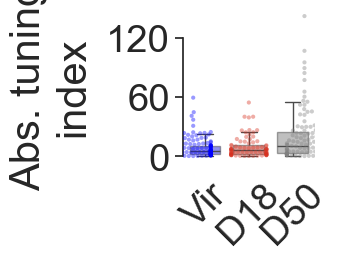

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: t_abs    
No. Observations:  239     Method:             REML     
No. Groups:        5       Scale:              55.9518  
Min. group size:   24      Log-Likelihood:     -821.0101
Max. group size:   72      Converged:          Yes      
Mean group size:   47.8                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       5.525    1.314 4.205 0.000  2.950  8.101
State[T.virgin] 2.222    1.046 2.124 0.034  0.172  4.272
Group Var       4.764    0.593                          



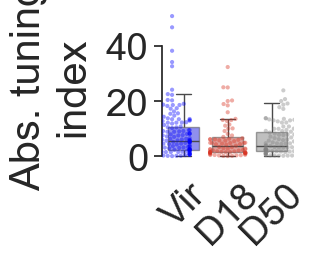

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: t_abs    
No. Observations:   187     Method:             REML     
No. Groups:         5       Scale:              104.8833 
Min. group size:    20      Log-Likelihood:     -702.5140
Max. group size:    66      Converged:          Yes      
Mean group size:    37.4                                 
---------------------------------------------------------
                Coef.  Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        6.391    3.839 1.665 0.096 -1.133 13.915
State[T.virgin]  5.493    2.405 2.284 0.022  0.780 10.206
Group Var       47.622    3.590                          



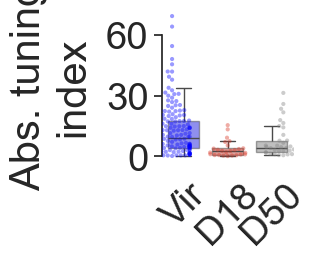

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  t_abs    
No. Observations:  177      Method:              REML     
No. Groups:        4        Scale:               63.7977  
Min. group size:   24       Log-Likelihood:      -618.3527
Max. group size:   66       Converged:           No       
Mean group size:   44.2                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        8.409    1.820  4.621 0.000  4.842 11.976
State[T.virgin] -0.400    1.572 -0.254 0.799 -3.480  2.680
Group Var        5.148    0.796                           



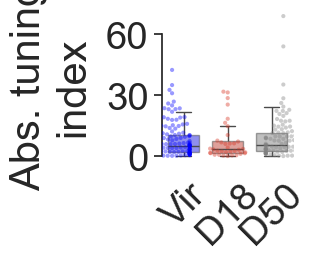

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: t_abs    
No. Observations:  177     Method:             REML     
No. Groups:        4       Scale:              66.0708  
Min. group size:   24      Log-Likelihood:     -621.6686
Max. group size:   66      Converged:          Yes      
Mean group size:   44.2                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       3.137    1.925 1.629 0.103 -0.637  6.910
State[T.virgin] 5.216    1.594 3.272 0.001  2.091  8.342
Group Var       6.624    0.859                          



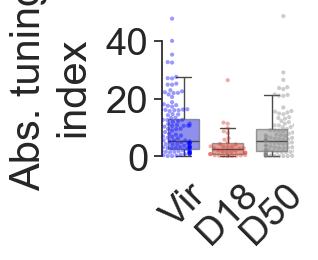

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: t_abs    
No. Observations:  197     Method:             REML     
No. Groups:        5       Scale:              24.0848  
Min. group size:   7       Log-Likelihood:     -593.8866
Max. group size:   66      Converged:          Yes      
Mean group size:   39.4                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       4.430    0.953 4.648 0.000  2.562  6.298
State[T.virgin] 1.578    0.861 1.834 0.067 -0.109  3.264
Group Var       1.960    0.404                          



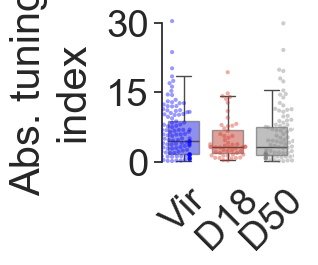

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  t_abs    
No. Observations:  92       Method:              REML     
No. Groups:        4        Scale:               21.6079  
Min. group size:   10       Log-Likelihood:      -272.5485
Max. group size:   47       Converged:           No       
Mean group size:   23.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z   P>|z|  [0.025 0.975]
----------------------------------------------------------
Intercept        5.105    2.777 1.838 0.066  -0.338 10.549
State[T.virgin]  0.500    5.457 0.092 0.927 -10.196 11.196
Group Var       21.608                                    



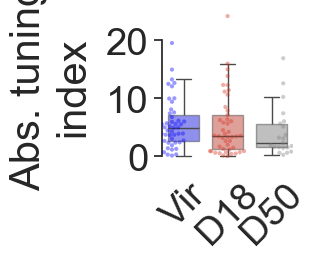

In [9]:
for behav in behaviours:
    
    t_data = neurons[neurons.Behaviour == behav]
    
# #     compute statistics per behaviour
    stats_df = t_data[(t_data.State.isin(['virgin', 'PD18']))] #virgin
    stats_df = stats_df.reset_index(drop = True)
    md = smf.mixedlm("t_abs ~ State", stats_df, groups=stats_df['IDs'])
    mdf = md.fit(method=["bfgs"]) #lbfgs
    
    print(mdf.summary())
    
    
    #plot distribution
    sns.set(font_scale=2.5) 
    sns.set_style("ticks")
    try:
        
        plt.subplots(figsize=[1.7,2])
        ax = sns.boxplot(x = 'State', y = 't_abs', data = t_data,  palette = ['#0000ff', '#d7301f', 'grey'], boxprops=dict(alpha=.5), showfliers=False, width = 0.7)
        ax = sns.swarmplot(x = 'State', y = 't_abs', data = t_data,  dodge = True, palette = ['#0000ff', '#d7301f', 'grey'], alpha = 0.4, size = 3)

        ax.set_xticklabels( ('Vir', 'D18', 'D50'), rotation=45)
        ax.set_xlabel('')
        ax.set_ylabel('Abs. tuning\nindex', labelpad=10)
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        sns.despine(bottom=True, trim=True)
        ax.tick_params(bottom=False)

#         plt.title(behav, pad=50)
#         plt.ylim(-10, 120)
        # plt.savefig(export_path + behav + '_t_abs.pdf', dpi = 300, bbox_inches='tight')
        plt.show()
    except ValueError:
        continue
 

## plot proportion of neurons which have increased / decreased evoked activities

In [22]:
states = ['virgin', 'PD18', 'PD50']
mylabels = ['No change', 'Decreasing', 'Increasing']
behaviours = ['pup sniff', 'retrieval to nest', 'pup groom', 'nest time', 'male intruder contact', 'female intruder contact', 'crouching'] # JK added pup groom
plt.rcParams['font.family'] = 'serif'
colors = ['dimgray', 'tab:blue', 'tab:orange']

proportions =  pd.DataFrame(columns = ['State', 
                                  'Behaviour', 
                                  'IDs',
                                  'No change',
                                  'Decreasing',
                                  'Increasing'])

for state in states:
    for ID in IDs:
    
        for behaviour in behaviours:
            
            
            proportion_change = []
            state_dat = neurons[(neurons.IDs == ID) &
                                (neurons.State == state)&
                                (neurons.Behaviour == behaviour)]
            
            if state_dat.empty:
                
                continue
    

            changes = state_dat[state_dat.Significance == 'Significant'].Change

            proportion = {}
            proportion['State'] = [state] 
            proportion['Behaviour'] = [behaviour] 
            proportion['IDs'] = [ID]


            for change in mylabels:
                
                   

                if change == 'No change':
                    changed = [state_dat.Significance == 'Not_Significant']
                    proportion['No change'] = [np.sum(changed)/len(state_dat.Change)]


                else:
                    changed = [changes == change]
                    proportion[change] = [np.sum(changed)/len(state_dat.Change)]

            proportion = pd.DataFrame(proportion)
            proportions = pd.concat([proportions, proportion])

proportions.to_csv('generated_dataset/proportions.csv')

In [11]:
behav = 'retrieval to nest'

behav = np.array(proportions['Behaviour'] == behav).astype(int)

subset = behav
subset = subset == 1
subset = proportions[subset]


_, p1 = stats.ttest_rel(subset[subset.State == 'virgin']['Increasing'], 
                       subset[subset.State == 'PD18']['Increasing'])

com_ids = ['JKAA40.3e','JKAA40.4i', 'JKAA40.4h', 'JKAA44.2i']
_, p2 = stats.ttest_rel(subset[(subset.State == 'PD18') & subset.IDs.isin(com_ids)]['Increasing'], 
                       subset[(subset.State == 'PD50')& subset.IDs.isin(com_ids)]['Increasing'])

print(p1, p2)

0.018439913071591818 0.0746335960393153


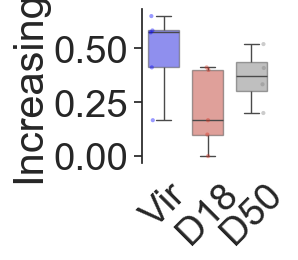

In [12]:
trend = 'Increasing'
behaviour = 'retrieval to nest'

sns.set_style("ticks")

behav = np.array(proportions['Behaviour'] == behaviour).astype(int)

subset = behav
subset = subset == 1
subset = proportions[subset]
fig, ax = plt.subplots(figsize=[1.7,2])
sns.boxplot(x = 'State', y = trend, data = subset,palette = ['#0000ff', '#d7301f', 'grey'], boxprops=dict(alpha=.5), showfliers=False, width = 0.7)
sns.stripplot(x = 'State', y = trend, data = subset, dodge = True, palette = ['#0000ff', '#d7301f', 'grey'], alpha = 0.4, size = 3)

ax.set_xticklabels( ('Vir', 'D18', 'D50'), rotation=45)
ax.set_xlabel('')

ax.yaxis.set_major_locator(plt.MaxNLocator(3))
sns.despine(bottom=True)
ax.tick_params(bottom=False)
# plt.savefig(export_path + f'{behaviour}_{trend}_fraction_VirD18D50.pdf', dpi = 300, bbox_inches='tight', transparent=True)

## Paired plot with VIR-D18-D50

In [13]:
# this cell selects the behaviour type and formats the data for plotting the custom double line plot 
behaviour = 'pup sniff' # change behaviour type here ('pup sniff' vs 'retrieval to nest' vs 'pup groom')
trend = 'Increasing'

behav = np.array(proportions['Behaviour'] == behaviour).astype(int)
subset = behav
subset = subset == 1
subset = proportions[subset]
lenVir = len(subset[(subset['State'] == 'virgin')])
lenD18 = len(subset[(subset['State'] == 'PD18')])
lenD50 = len(subset[(subset['State'] == 'PD50')])
# subset

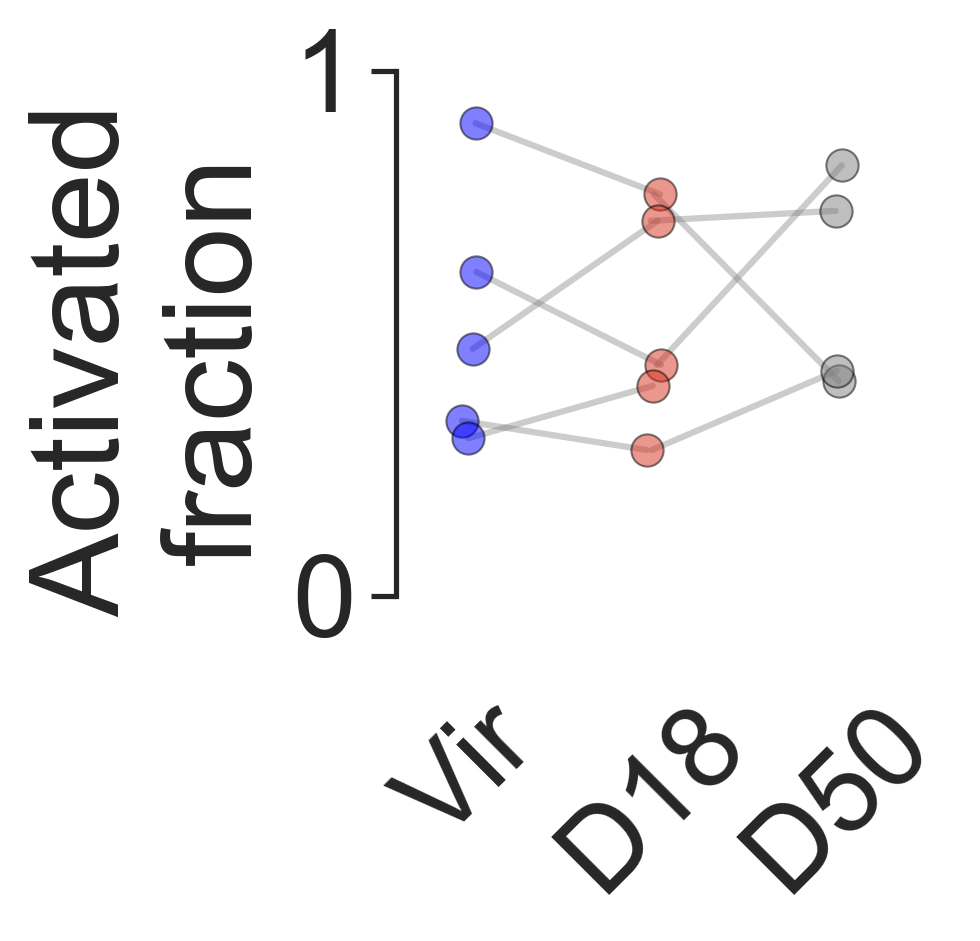

In [14]:
# PAIRED PLOT WITH VIR-D18-D50 --> make sure to change Y label ('Activated vs inhibited fraction') depending on trend!
sns.set(rc={"figure.figsize": (2, 2.5)}) #1.75, 2.5
plt.rcParams['figure.dpi'] = 300
sns.set(font_scale=2.5) 
sns.set_style("ticks")

# add lineplots; first add x values = number of mice in each group
arr = np.random.normal(0, 0.02, lenVir) #for jitter: generate random numbers for n number of mice
arr50 = np.random.normal(0, 0.02, lenD50) # we need a separate one for D50 because there's only 4 mice at this stage, not 5 as in Vir/D18
arr_y = np.random.normal(0, 0, lenVir) #0, 0.01
arr_y50 = np.random.normal(0, 0, lenD50) #0, 0.01

x1 = np.zeros(lenVir)+arr
x2 = np.ones(lenD18)+arr
x23 = np.ones(lenD50)+arr50 # this one is necessary b/c there will be fewer lines from D18 to D50
x3 = np.zeros(lenD50)+arr50+2

# then extract the corresponding y values
y1 = subset[(subset['State'] == 'virgin')][trend] + arr_y
y2 = subset[(subset['State'] == 'PD18')][trend] + arr_y
y23 = y2[:-1] # remove last item from list; this one is necessary b/c there will be fewer lines from D18 to D50
y3 = subset[(subset['State'] == 'PD50')][trend] + arr_y50

plt.scatter(x1, y1, color='#0000ff', linewidth=0.5, edgecolor='black', s=60, alpha=0.5)
plt.scatter(x2, y2, color='#d7301f', linewidth=0.5, edgecolor='black', s=60, alpha=0.5)
plt.scatter(x3, y3, color='gray', linewidth=0.5, edgecolor='black', s=60, alpha=0.5)

plt.ylabel('Activated\nfraction')
plt.ylim(-0.1,1)
plt.xlim(-0.4, )

# plotting the lines
# plt.plot( [x1,x2,x3], [y1,y2,y3], color='grey', alpha=.2, zorder=0)
plt.plot( [x1,x2], [y1,y2], color='grey', alpha=.4, zorder=0) #0.2
plt.plot( [x23,x3], [y23,y3], color='grey', alpha=.4, zorder=0)

# plot x ticks and labels btw bars
cats = np.array(['Vir', 'D18', 'D50'])
u = np.arange(len(cats))
plt.xticks(u, cats, rotation=45)
# sns.despine()
sns.despine(bottom=True, trim=True)
plt.tick_params(bottom=False)
# plt.savefig(export_path + f'{behaviour}_{trend}_fraction_VirD18D50.pdf', dpi = 300, bbox_inches='tight', transparent=True)

## quantify population amplitude in response to evoked activities (increased neuron only) 

### per neuron quantification

#### evoked activities

In [15]:
behaviours = ['retrieval to nest']
trend = 'Increasing'
Amps = pd.DataFrame(columns = ['State', 
                              'Behaviour', 
                              'IDs', 
                              'Mean_episode_amplitude',
                              'non_z'])
zscored = True

for state in states:
    for behaviour in behaviours:

        avg_amplitudes = []

        if zscored:

            amplitude = neurons[(neurons.State == state)&
                                (neurons.Behaviour == behaviour)&
                                (neurons.Change == trend)].Mean_episode_activity
        else:
            amplitude = neurons[(neurons.State == state)&
                                (neurons.Behaviour == behaviour)&
                                (neurons.Change == trend)].non_z

        if amplitude.empty :

            break

        amplitude = np.vstack(amplitude)
        # in the presence of infinity, set infinity value to 5
        amplitude = np.nan_to_num(amplitude)
        amplitude[amplitude >5] = 5 
       


        Amp= {}
        Amp['State'] = [state] 
        Amp['Behaviour'] = [behaviour] 
        # Amp['Amplitude'] = [avg_amplitude]
        Amp['Amplitude'] = [amplitude]
        Amp = pd.DataFrame(Amp)
        Amps = pd.concat([Amps, Amp])   


Amp_v = Amps[Amps.State == 'virgin']   
Amp_v_mean = Amp_v.Amplitude[0].mean(axis = 0)
Amp_v_err = Amp_v.Amplitude[0].std(axis = 0)/ np.sqrt(Amp_v.Amplitude[0].shape[0])

Amp_P = Amps[Amps.State == 'PD18']
Amp_P_mean = Amp_P.Amplitude[0].mean(axis = 0)
Amp_P_err = Amp_P.Amplitude[0].std(axis = 0)/ np.sqrt(Amp_P.Amplitude[0].shape[0])

Amp_D = Amps[Amps.State == 'PD50']
Amp_D_mean = Amp_D.Amplitude[0].mean(axis = 0)
Amp_D_err = Amp_D.Amplitude[0].std(axis = 0)/ np.sqrt(Amp_D.Amplitude[0].shape[0])




In [16]:
#stats for when the z-scored traces become different
for time in range(fr*window*2):
    _, p = stats.ttest_ind(Amp_v.Amplitude[0].T[time], 
                           Amp_P.Amplitude[0].T[time])
    if p <0.05:
        print(time, p)

0 0.0008397376587972785
1 0.031208704282676893
2 0.029405722314879895
3 0.0015309508907643552
8 0.033688924619863676
48 0.029286132802805613
49 0.0060303504684432255
50 0.003418575807187551
51 0.027736454096349564
52 0.005162016872639285
53 0.00988137561359485
54 0.002595496094022658
55 0.034217516460335856
56 0.0030330121070611684
57 0.0007775805982268521
58 0.00469141636690031
59 0.0011513684627783767
60 0.03729894625992154
61 0.012609126844940085
63 0.027233104172635355
67 0.012054256097371648
71 0.01107987031913592
72 0.01294155662189798
73 0.009255940863759424
74 0.0034719350654093526
75 0.0015768712644454346
76 0.004180900499284872
77 0.0016703612570182775
79 0.010077161778396473


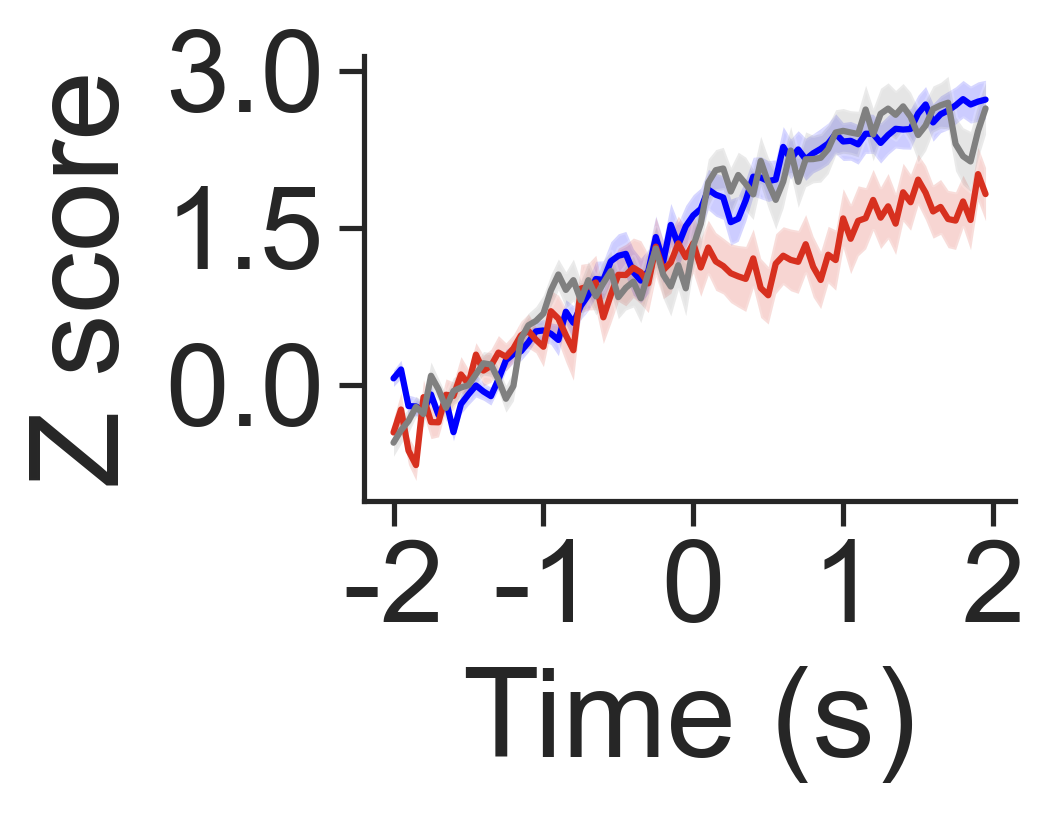

In [17]:
fig, ax = plt.subplots(figsize=[4, 3])
fig.tight_layout()


ax.set_xticks(np.arange(0, 2*window*fr+2,  fr))
ax.set_xticklabels(np.arange(-window*fr, window*fr+2 , fr) // ( fr))

plt.plot(Amp_v_mean, '#0000ff', alpha = 1)
plt.plot(Amp_P_mean, '#d7301f', alpha = 1)
plt.plot(Amp_D_mean, 'gray', alpha = 1)

line = ax.lines[0]
xrange = line.get_xdata()

plt.fill_between(xrange, Amp_v_mean + Amp_v_err, Amp_v_mean - Amp_v_err, alpha = 0.2, facecolor = '#0000ff')
plt.fill_between(xrange, Amp_P_mean + Amp_P_err, Amp_P_mean - Amp_P_err, alpha = 0.2, facecolor = '#d7301f')
plt.fill_between(xrange, Amp_D_mean + Amp_D_err, Amp_D_mean - Amp_D_err, alpha = 0.2, facecolor = 'gray')

plt.ylabel('Z score', labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
# plt.ylim(0,4) #0,5 for pup sniff
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig(export_path + behaviour + trend +'_Amplitude.pdf', dpi = 300, bbox_inches='tight')
# plt.savefig(export_path + behaviour + '_Amplitude.png', dpi = 300, bbox_inches='tight')

### quantify response amplitude to different social stimuli

In [18]:
behaviours = ['pup sniff', 'male intruder contact', 'female intruder contact']
Amps = pd.DataFrame(columns = ['State', 
                              'Behaviour'])

for state in states:
    for behaviour in behaviours:

        avg_amplitudes = []

       

        amplitude = neurons[(neurons.State == state)&
                            (neurons.Behaviour == behaviour)].Mean_episode_activity

        if amplitude.empty :

            break

        amplitude = np.vstack(amplitude)
        
        # in the presence of infinity, set infinity value to 5
        amplitude = np.nan_to_num(amplitude)
        amplitude[amplitude >5] = 5 
       


        Amp= {}
        
        Amp['State'] = [state] 
        Amp['Behaviour'] = [behaviour]
        Amp['Amplitude'] = [amplitude]
        Amp = pd.DataFrame(Amp)
        Amps = pd.concat([Amps, Amp])   


In [19]:
def mean_std_trace(amps, state, behaviour):
    amp = amps[(amps.State == state) & (amps.Behaviour == behaviour)] 
    amp_mean = amp.Amplitude[0].mean(axis = 0)
    amp_err = amp.Amplitude[0].std(axis = 0)/ np.sqrt(amp.Amplitude[0].shape[0])
    
    return amp, amp_mean, amp_err


In [20]:
for state in states:
    amp_p, _, _ = mean_std_trace(Amps, state, 'pup sniff')
    amp_f, _, _ = mean_std_trace(Amps, state, 'female intruder contact')
    amp_m, _, _ = mean_std_trace(Amps, state, 'male intruder contact')
    
    for time in range(fr*window*2):
        _, p1 = stats.ttest_ind(amp_p.Amplitude[0].T[time], 
                            amp_f.Amplitude[0].T[time])
        if p1 <0.05:
            print(state, 'pup+female', time, p1)
    for time in range(fr*window*2):
        _, p2 = stats.ttest_ind(amp_p.Amplitude[0].T[time], 
                            amp_m.Amplitude[0].T[time])
    
        if p2 <0.05:
            print(state, 'pup+ male', time, p2)

virgin pup+female 0 0.0024828931744594104
virgin pup+female 1 0.01145408623256915
virgin pup+female 14 0.046751652140458656
virgin pup+female 32 0.03087232751546659
virgin pup+female 33 0.04489244224334478
virgin pup+female 34 0.00156169058028577
virgin pup+female 35 0.040414308693619484
virgin pup+female 36 0.02102984115049921
virgin pup+female 37 0.018452127379406363
virgin pup+female 39 0.01169037179895795
virgin pup+female 40 0.003420300594039281
virgin pup+female 41 0.01359262969897507
virgin pup+female 42 0.002728204546698559
virgin pup+female 43 0.003242870977378641
virgin pup+female 44 0.00033818258261294077
virgin pup+female 45 0.011739924509324475
virgin pup+female 46 0.005226695217059258
virgin pup+female 47 0.021401439385736704
virgin pup+female 48 0.024949469716218264
virgin pup+female 49 0.0033953995849509764
virgin pup+female 50 0.0001362658415416334
virgin pup+female 51 0.0018198744192966221
virgin pup+female 52 0.0006622644411080486
virgin pup+female 53 0.0064024265636

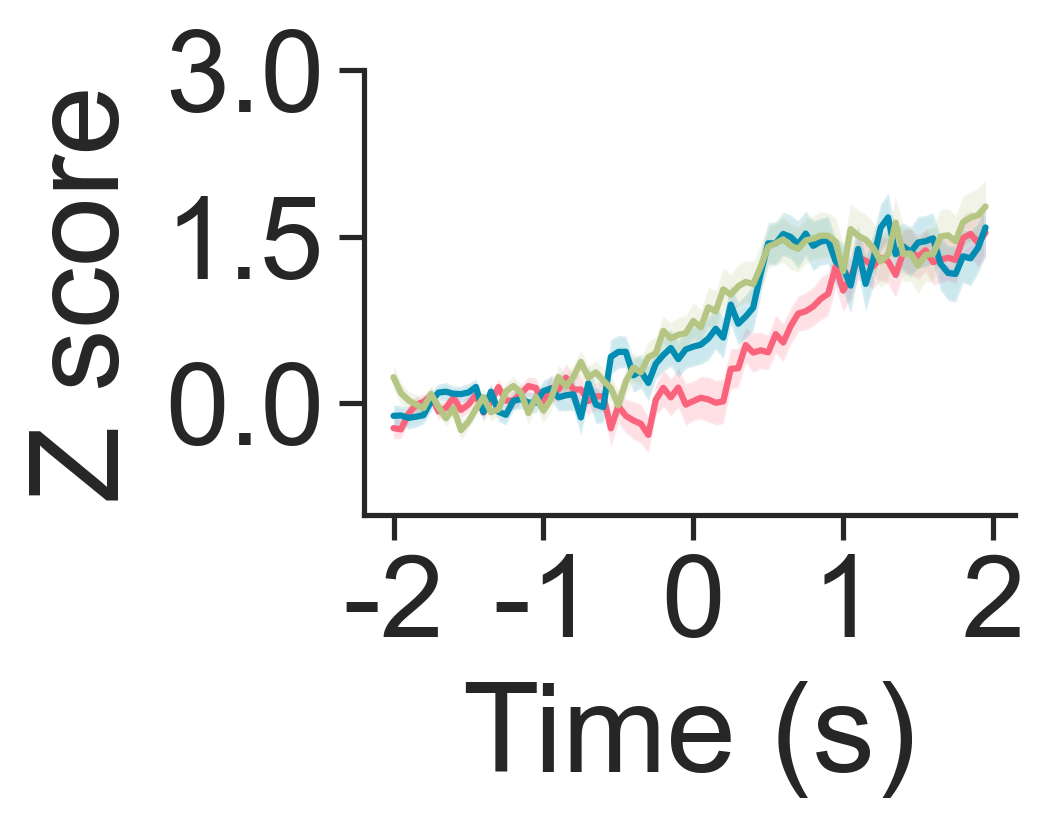

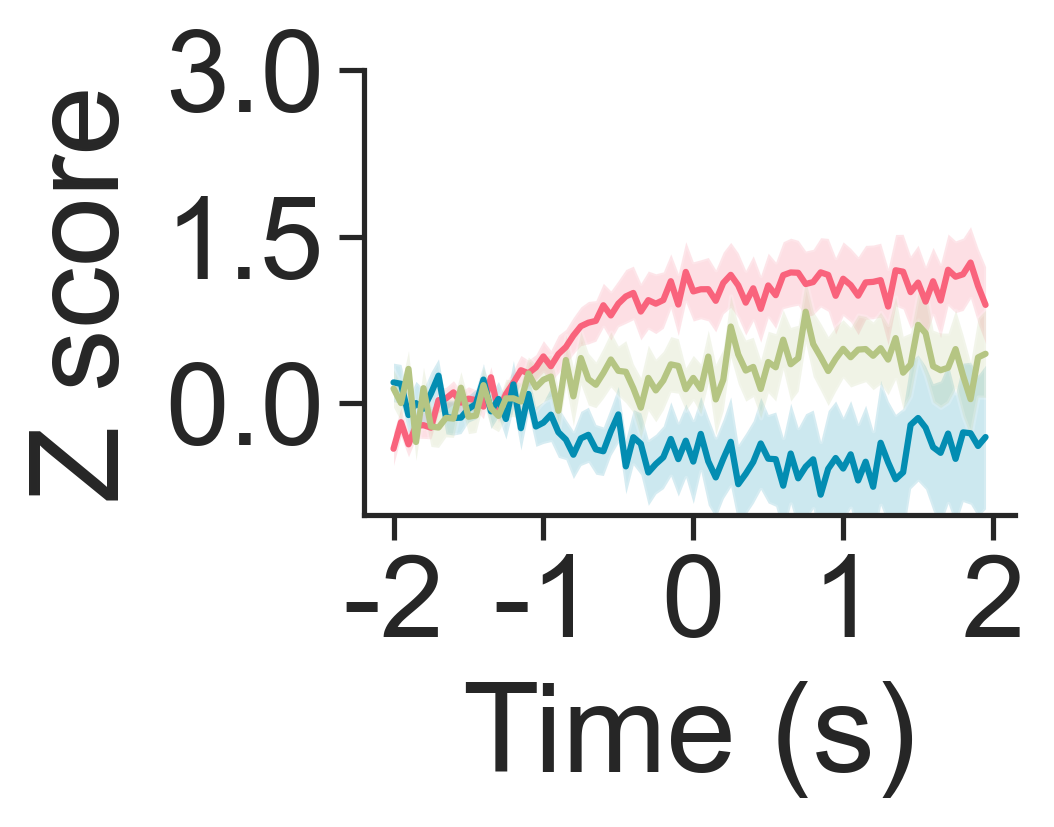

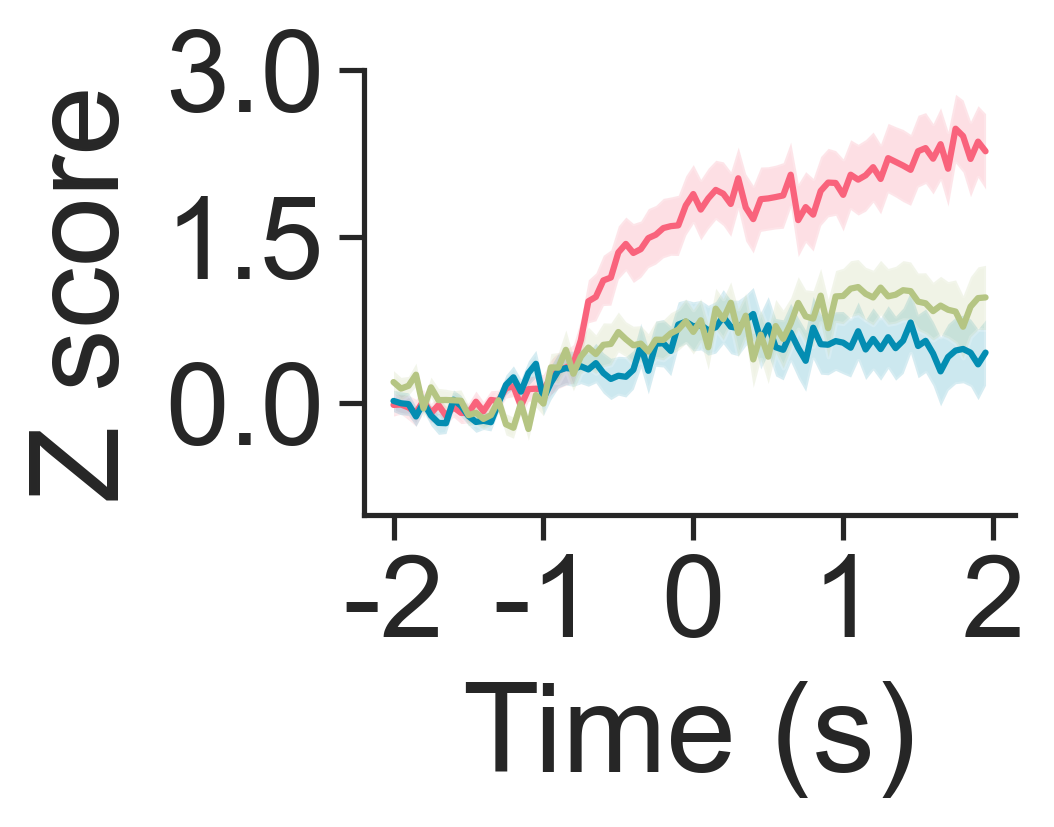

In [21]:
for state in states:
    _, amp_m_pup, amp_err_pup = mean_std_trace(Amps, state, 'pup sniff')
    _, amp_m_male, amp_err_male = mean_std_trace(Amps, state, 'male intruder contact')
    _, amp_m_female, amp_err_female = mean_std_trace(Amps, state, 'female intruder contact')
    
    
    fig, ax = plt.subplots(figsize=[4, 3])
    fig.tight_layout()


    ax.set_xticks(np.arange(0, 2*window*fr+2,  fr))
    ax.set_xticklabels(np.arange(-window*fr, window*fr+2 , fr) // ( fr))

    plt.plot(amp_m_pup, '#f9637c', alpha = 1)
    plt.plot(amp_m_male, '#038db2', alpha = 1)
    plt.plot(amp_m_female, '#b5c583', alpha = 1)

    line = ax.lines[0]
    xrange = line.get_xdata()

    plt.fill_between(xrange, amp_m_pup + amp_err_pup , amp_m_pup - amp_err_pup , alpha = 0.2, facecolor = '#f9637c')
    plt.fill_between(xrange, amp_m_male + amp_err_male, amp_m_male - amp_err_male , alpha = 0.2, facecolor = '#038db2')
    plt.fill_between(xrange, amp_m_female + amp_err_female, amp_m_female - amp_err_female, alpha = 0.2, facecolor = '#b5c583')

    plt.ylabel('Z score', labelpad=5)
    plt.xlabel('Time (s)', labelpad=5)
    plt.ylim(-1,3) #0,5 for pup sniff
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.savefig(export_path +state+ '_male_female_pup_Amplitude.pdf', dpi = 300, bbox_inches='tight')
